In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
df = pd.read_csv('updatedcreditcard.csv')
df.head()

,cc_num,merchant,category,amt,gender,street,city,state,zip,lat,...,merch_lat,merch_long,is_fraud,age,year,month,hour,day_of_week,age_group,distance_km
0,2.703190e+15,"fraud_Rippin, Kub and Mann",misc_net,4.97,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,...,36.011293,-82.048315,0,30,2019,1,0,1,25-34,78.597568
1,6.304230e+11,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,...,49.159047,-118.186462,0,40,2019,1,0,1,35-44,30.212176
2,3.885950e+13,fraud_Lind-Buckridge,entertainment,220.11,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,...,43.150704,-112.154481,0,56,2019,1,0,1,55-64,108.206083
3,3.534090e+15,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,...,47.034331,-112.561071,0,51,2019,1,0,1,45-54,95.673231
4,3.755340e+14,fraud_Keeling-Crist,misc_pos,41.96,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,...,38.674999,-78.632459,0,32,2019,1,0,1,25-34,77.556744


RFE SMOTE XGBOOST - Train Test Split

In [2]:
# 1) IMPORTS & SETUP
# -----------------------------------------------------------
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Sklearn / ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.metrics import classification_report, confusion_matrix

# XGBoost (CPU-based)
import xgboost as xgb

# Advanced encoding for high-cardinality or single-col cat
from category_encoders import TargetEncoder

# For synthetic sampling (SMOTE)
from imblearn.over_sampling import SMOTE

# Optional progress bar
from tqdm import tqdm

In [3]:
# 2) DROP USELESS COLUMNS & DEFINE FEATURES
# -----------------------------------------------------------
"""
We keep:
   category, amt, gender, city, state, city_pop, job, is_fraud,
   age, year, month, hour, day_of_week, distance_km, amt_bin, dist_bin, citypop_bin
Drop duplicates, IDs, etc., if not already done.
"""

useful_cols = [
    "category", "amt", "gender", "city", "state", "city_pop", "job",
    "is_fraud", "age", "year", "month", "hour", "day_of_week", 
 "distance_km"
 #"amt_bin", "dist_bin", "citypop_bin"
]

df_clean = df[useful_cols].copy()
df_clean.dropna(inplace=True)

# X, y
X = df_clean.drop(columns=["is_fraud"])
y = df_clean["is_fraud"].astype(int)

print("Initial shape of X:", X.shape)
print("Initial shape of y:", y.shape)
print("Class distribution:\n", y.value_counts(normalize=True) * 100, "%")

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print("\nTraining set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)
print("Train set class distribution:\n", y_train.value_counts(normalize=True)*100, "%")
print("Test set class distribution:\n", y_test.value_counts(normalize=True)*100, "%")

Initial shape of X: (1048575, 13)
Initial shape of y: (1048575,)
Class distribution:
 is_fraud
0    99.427223
1     0.572777
Name: proportion, dtype: float64 %

Training set shape: (786431, 13) (786431,)
Test set shape: (262144, 13) (262144,)
Train set class distribution:
 is_fraud
0    99.427286
1     0.572714
Name: proportion, dtype: float64 %
Test set class distribution:
 is_fraud
0    99.427032
1     0.572968
Name: proportion, dtype: float64 %


In [4]:
# 3) DEFINE COLUMN GROUPS FOR ENCODING
# -----------------------------------------------------------
numeric_features = [
    "amt", "distance_km", "age", "city_pop", 
    "year", "month", "hour", "day_of_week"
]

cat_small = ["gender"]  # one-hot
cat_high = ["city", "state", "job", "category"]  # target encode

In [5]:
# 4) BUILD COLUMNTRANSFORMER
# -----------------------------------------------------------
from sklearn.pipeline import make_pipeline

numeric_transformer = Pipeline([
    ("scaler", StandardScaler())
])

ohe_transformer = Pipeline([
    ("ohe", OneHotEncoder(drop='first', handle_unknown='ignore'))
])

target_encoder = Pipeline([
    ("target_enc", TargetEncoder(smoothing=0.3))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("ohe", ohe_transformer, cat_small),
        ("te", target_encoder, cat_high),
    ],
    remainder="drop"
)


[INFO] Shape of X_train_enc BEFORE SMOTE: (786431, 13)
Class distribution in y_train BEFORE SMOTE: [781927   4504]


/var/folders/z9/cvzm0bkn2gv0qywmh29rgvrr0000gn/T/ipykernel_93601/2064482391.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Non-Fraud (0)", "Fraud (1)"])


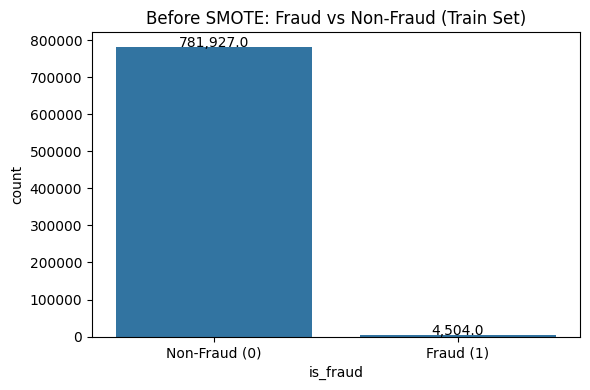


[INFO] Shape of X_train_enc AFTER SMOTE: (1563854, 13)
Class distribution in y_train AFTER SMOTE: [781927 781927]


/var/folders/z9/cvzm0bkn2gv0qywmh29rgvrr0000gn/T/ipykernel_93601/2064482391.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Non-Fraud (0)", "Fraud (1)"])


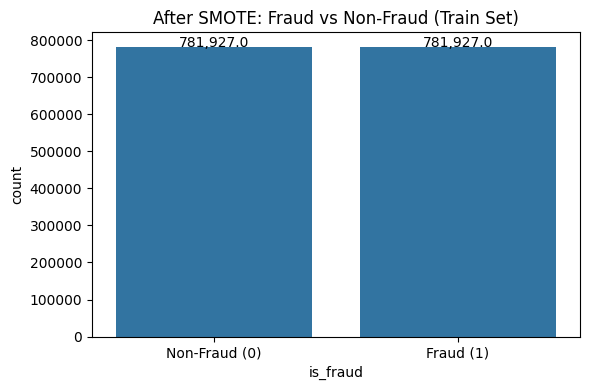


[DEBUG] We have 13 total features after encoding.


In [6]:
# 5) TRANSFORM + SMOTE
# -----------------------------------------------------------
X_train_enc = preprocessor.fit_transform(X_train, y_train)
X_test_enc  = preprocessor.transform(X_test)

print("\n[INFO] Shape of X_train_enc BEFORE SMOTE:", X_train_enc.shape)
print("Class distribution in y_train BEFORE SMOTE:", np.bincount(y_train))

# Make a quick bar chart of Fraud vs Non-Fraud in y_train
fig, ax = plt.subplots(figsize=(6,4))
sns.countplot(x=y_train, ax=ax)
ax.set_title("Before SMOTE: Fraud vs Non-Fraud (Train Set)")
ax.set_xticklabels(["Non-Fraud (0)", "Fraud (1)"])
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height+50, f"{height:,}", 
            ha="center", fontsize=10)
plt.tight_layout()
plt.show()

# Apply SMOTE
sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train_enc, y_train)

print("\n[INFO] Shape of X_train_enc AFTER SMOTE:", X_train_sm.shape)
print("Class distribution in y_train AFTER SMOTE:", np.bincount(y_train_sm))

# Plot new distribution
fig, ax = plt.subplots(figsize=(6,4))
sns.countplot(x=y_train_sm, ax=ax)
ax.set_title("After SMOTE: Fraud vs Non-Fraud (Train Set)")
ax.set_xticklabels(["Non-Fraud (0)", "Fraud (1)"])
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height+50, f"{height:,}", 
            ha="center", fontsize=10)
plt.tight_layout()
plt.show()

# Reconstruct final column names
from sklearn.preprocessing import OneHotEncoder
ohe_step = preprocessor.named_transformers_['ohe'].named_steps['ohe']
ohe_feature_names = ohe_step.get_feature_names_out(cat_small)
te_cols = ["city_te", "state_te", "job_te", "category_te"]
final_feature_names = numeric_features + list(ohe_feature_names) + te_cols
print("\n[DEBUG] We have", len(final_feature_names), "total features after encoding.")

In [7]:
# -----------------------------------------------------------
# 6) FEATURE SELECTION (RFE) USING XGBoost
# -----------------------------------------------------------
from sklearn.metrics import accuracy_score

xgb_clf = xgb.XGBClassifier(
    n_estimators=100,
    random_state=42,
    verbosity=1,
    tree_method='hist'
)

rfe = RFE(
    estimator=xgb_clf,
    n_features_to_select=10,
    step=1,
    verbose=1
)

print("\n[DEBUG] Starting RFE fit... (this may take a while)")
rfe.fit(X_train_sm, y_train_sm)

# -----------------------------------------------------------
# 7) PRINT SELECTED FEATURES
# -----------------------------------------------------------
support_mask = rfe.support_
ranking = rfe.ranking_
print("\n[DEBUG] RFE Feature Ranking Results:")
for i, feat_name in enumerate(final_feature_names):
    print(f"{i}: {feat_name} | Support={support_mask[i]}, Rank={ranking[i]}")

selected_features = [f for f, s in zip(final_feature_names, support_mask) if s]
print("\n=== SELECTED FEATURES by RFE ===")
for feat in selected_features:
    print("   -", feat)

# Transform the data to keep only selected features
X_train_sel = rfe.transform(X_train_sm)
X_test_sel  = rfe.transform(X_test_enc)


[DEBUG] Starting RFE fit... (this may take a while)
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.

[DEBUG] RFE Feature Ranking Results:
0: amt | Support=True, Rank=1
1: distance_km | Support=False, Rank=4
2: age | Support=True, Rank=1
3: city_pop | Support=False, Rank=2
4: year | Support=False, Rank=3
5: month | Support=True, Rank=1
6: hour | Support=True, Rank=1
7: day_of_week | Support=True, Rank=1
8: gender_M | Support=True, Rank=1
9: city_te | Support=True, Rank=1
10: state_te | Support=True, Rank=1
11: job_te | Support=True, Rank=1
12: category_te | Support=True, Rank=1

=== SELECTED FEATURES by RFE ===
   - amt
   - age
   - month
   - hour
   - day_of_week
   - gender_M
   - city_te
   - state_te
   - job_te
   - category_te


In [8]:
# -----------------------------------------------------------
# 8) TRAIN FINAL XGBOOST MODEL ON SELECTED FEATURES
# -----------------------------------------------------------
final_xgb = xgb.XGBClassifier(
    n_estimators=100,
    random_state=42,
    verbosity=1,
    tree_method='hist'
)

print("\n[DEBUG] Training final XGBoost on selected features...")
final_xgb.fit(X_train_sel, y_train_sm)

# -----------------------------------------------------------
# 9) EVALUATE ON TEST SET
# -----------------------------------------------------------
y_pred = final_xgb.predict(X_test_sel)
print("\n=== MODEL PERFORMANCE (XGBoost + SMOTE + RFE) [TEST] ===")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# -----------------------------------------------------------
# 10) OVERFITTING CHECK: TRAIN PERFORMANCE
# -----------------------------------------------------------
train_pred = final_xgb.predict(X_train_sel)
print("\n=== MODEL PERFORMANCE (XGBoost) [TRAIN] ===")
print("Accuracy (Train):", accuracy_score(y_train_sm, train_pred))
print("Classification Report (Train):\n", classification_report(y_train_sm, train_pred))
print("Confusion Matrix (Train):\n", confusion_matrix(y_train_sm, train_pred))

print("\n[INFO] Done! RFE selected features are printed first, then final XGBoost is trained and evaluated.")



[DEBUG] Training final XGBoost on selected features...

=== MODEL PERFORMANCE (XGBoost + SMOTE + RFE) [TEST] ===
Accuracy: 0.998260498046875
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    260642
           1       0.85      0.85      0.85      1502

    accuracy                           1.00    262144
   macro avg       0.92      0.92      0.92    262144
weighted avg       1.00      1.00      1.00    262144

Confusion Matrix:
 [[260412    230]
 [   226   1276]]

=== MODEL PERFORMANCE (XGBoost) [TRAIN] ===
Accuracy (Train): 0.9990203689091182
Classification Report (Train):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    781927
           1       1.00      1.00      1.00    781927

    accuracy                           1.00   1563854
   macro avg       1.00      1.00      1.00   1563854
weighted avg       1.00      1.00      1.00   1563854

Confusion Ma

Train Test Validation - RFE XGBOOST and RandomForest 

XGBOOST

Initial shape of X: (1048575, 13)
Initial shape of y: (1048575,)
Class distribution:
 is_fraud
0    99.427223
1     0.572777
Name: proportion, dtype: float64 %

=== FINAL SPLITS ===
Train shape: (838860, 13) (838860,)
Validation shape: (104857, 13) (104857,)
Test shape: (104858, 13) (104858,)

Train class distribution:
 is_fraud
0    99.427199
1     0.572801
Name: proportion, dtype: float64 %
Val class distribution:
 is_fraud
0    99.427792
1     0.572208
Name: proportion, dtype: float64 %
Test class distribution:
 is_fraud
0    99.426844
1     0.573156
Name: proportion, dtype: float64 %

[INFO] Shape of X_train_enc BEFORE SMOTE: (838860, 13)
Class distribution in y_train_temp BEFORE SMOTE: [834055   4805]

[INFO] Shape of X_train_enc AFTER SMOTE: (1668110, 13)
Class distribution in y_train_sm AFTER SMOTE: [834055 834055]

[DEBUG] Final Encoded Feature List (Train/Val/Test share):
['amt', 'distance_km', 'age', 'city_pop', 'year', 'month', 'hour', 'day_of_week', 'gender_M', 'city_te', '

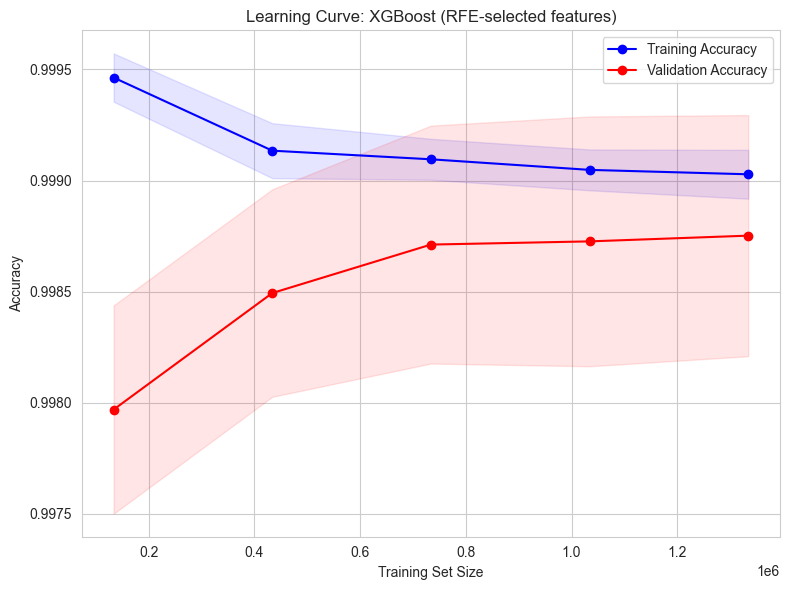

In [9]:
# -----------------------------------------------------------
# 1) IMPORTS & SETUP
# -----------------------------------------------------------
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Sklearn / ML
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# XGBoost (CPU-based)
import xgboost as xgb

# RandomForest
from sklearn.ensemble import RandomForestClassifier

# Advanced encoding for high-cardinality or single-col cat
from category_encoders import TargetEncoder

# For synthetic sampling (SMOTE)
from imblearn.over_sampling import SMOTE

# Optional progress bar
from tqdm import tqdm

sns.set_style("whitegrid")

# -----------------------------------------------------------
# 2) LOAD DATA & SPLIT INTO TRAIN/VALIDATION/TEST
# -----------------------------------------------------------
"""
We assume your DataFrame is named 'df' with columns:

   'category','amt','gender','city','state','city_pop','job',
   'is_fraud','age','year','month','hour','day_of_week',
   'distance_km','amt_bin','dist_bin','citypop_bin'

Adjust if needed.
"""

useful_cols = [
    "category", "amt", "gender", "city", "state", "city_pop", "job",
    "is_fraud", "age", "year", "month", "hour", "day_of_week", 
    "distance_km"
]

df_clean = df[useful_cols].copy()
df_clean.dropna(inplace=True)

X = df_clean.drop(columns=["is_fraud"])
y = df_clean["is_fraud"].astype(int)

print("Initial shape of X:", X.shape)
print("Initial shape of y:", y.shape)
print("Class distribution:\n", y.value_counts(normalize=True)*100, "%")

# First split: 80% Train + 20% Temp
X_train_temp, X_temp, y_train_temp, y_temp = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Second split: 50% of Temp → Val, 50% of Temp → Test
# => 70% Train, 10% Validation, 20% Test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_temp
)

print("\n=== FINAL SPLITS ===")
print("Train shape:", X_train_temp.shape, y_train_temp.shape)
print("Validation shape:", X_val.shape, y_val.shape)
print("Test shape:", X_test.shape, y_test.shape)

print("\nTrain class distribution:\n", y_train_temp.value_counts(normalize=True)*100, "%")
print("Val class distribution:\n", y_val.value_counts(normalize=True)*100, "%")
print("Test class distribution:\n", y_test.value_counts(normalize=True)*100, "%")

# -----------------------------------------------------------
# 3) COLUMN GROUPS FOR ENCODING
# -----------------------------------------------------------
numeric_features = [
    "amt", "distance_km", "age", "city_pop", 
    "year", "month", "hour", "day_of_week"
]
cat_small = ["gender"]             # one-hot
cat_high  = ["city","state","job","category"]  # target-encode

# -----------------------------------------------------------
# 4) COLUMNTRANSFORMER (SCALING + ENCODING)
# -----------------------------------------------------------
from sklearn.pipeline import make_pipeline

numeric_transformer = Pipeline([
    ("scaler", StandardScaler())
])

ohe_transformer = Pipeline([
    ("ohe", OneHotEncoder(drop='first', handle_unknown='ignore'))
])

target_encoder = Pipeline([
    ("target_enc", TargetEncoder(smoothing=0.3))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("ohe", ohe_transformer, cat_small),
        ("te", target_encoder, cat_high),
    ],
    remainder="drop"
)

# -----------------------------------------------------------
# 5) FIT PREPROCESSOR & APPLY SMOTE (TRAIN ONLY)
# -----------------------------------------------------------
X_train_enc = preprocessor.fit_transform(X_train_temp, y_train_temp)
print("\n[INFO] Shape of X_train_enc BEFORE SMOTE:", X_train_enc.shape)
print("Class distribution in y_train_temp BEFORE SMOTE:", np.bincount(y_train_temp))

sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train_enc, y_train_temp)

print("\n[INFO] Shape of X_train_enc AFTER SMOTE:", X_train_sm.shape)
print("Class distribution in y_train_sm AFTER SMOTE:", np.bincount(y_train_sm))

# -----------------------------------------------------------
# 6) ENCODE VAL & TEST WITHOUT REFITTING PREPROCESSOR
# -----------------------------------------------------------
X_val_enc  = preprocessor.transform(X_val)
X_test_enc = preprocessor.transform(X_test)

# Build final feature name list
ohe_step = preprocessor.named_transformers_['ohe'].named_steps['ohe']
ohe_feature_names = ohe_step.get_feature_names_out(cat_small)
te_cols = [f"{col}_te" for col in cat_high]
final_feature_names = numeric_features + list(ohe_feature_names) + te_cols

print("\n[DEBUG] Final Encoded Feature List (Train/Val/Test share):")
print(final_feature_names)

# ===========================================================
# PART A: XGBOOST 
# ===========================================================
print("\n==================== XGBOOST PIPELINE ====================\n")

# -----------------------------------------------------------
# A.1) RFE USING XGBoost ON TRAIN
# -----------------------------------------------------------
xgb_clf = xgboost_model = xgb.XGBClassifier(
    n_estimators=100,
    random_state=42,
    verbosity=1,
    tree_method='hist'
)

xgb_rfe = RFE(
    estimator=xgb_clf,
    n_features_to_select=10,
    step=1,
    verbose=1
)

print("\n[DEBUG] Starting RFE fit (XGBoost) on TRAIN ONLY... (this may take a while)")
xgb_rfe.fit(X_train_sm, y_train_sm)

xgb_support_mask = xgb_rfe.support_
xgb_ranking = xgb_rfe.ranking_

print("\n[DEBUG] XGBoost RFE Feature Ranking Results:")
for i, feat_name in enumerate(final_feature_names):
    print(f"{i}: {feat_name} | Support={xgb_support_mask[i]}, Rank={xgb_ranking[i]}")

xgb_selected_features = [f for f, s in zip(final_feature_names, xgb_support_mask) if s]
print("\n=== SELECTED FEATURES by XGBoost RFE ===")
for feat in xgb_selected_features:
    print("   -", feat)

X_train_sel_xgb = xgb_rfe.transform(X_train_sm)
X_val_sel_xgb   = xgb_rfe.transform(X_val_enc)
X_test_sel_xgb  = xgb_rfe.transform(X_test_enc)

# -----------------------------------------------------------
# A.2) TRAIN FINAL XGBOOST ON SELECTED FEATURES (TRAIN ONLY)
# -----------------------------------------------------------
final_xgb = xgb.XGBClassifier(
    n_estimators=100,
    random_state=42,
    verbosity=1,
    tree_method='hist'
)

print("\n[DEBUG] Training final XGBoost on selected features (TRAIN ONLY)...")
final_xgb.fit(X_train_sel_xgb, y_train_sm)

# -----------------------------------------------------------
# A.3) EVALUATE ON TRAIN SET FIRST (OVERFITTING CHECK)
# -----------------------------------------------------------
xgb_train_pred = final_xgb.predict(X_train_sel_xgb)
xgb_train_acc  = accuracy_score(y_train_sm, xgb_train_pred)

print("\n=== [XGBoost] MODEL PERFORMANCE ON TRAIN SET (WITH SMOTE) ===")
print("Accuracy (Train):", xgb_train_acc)
print("Classification Report (Train):\n", classification_report(y_train_sm, xgb_train_pred))
print("Confusion Matrix (Train):\n", confusion_matrix(y_train_sm, xgb_train_pred))

# -----------------------------------------------------------
# A.4) EVALUATE ON VALIDATION SET
# -----------------------------------------------------------
xgb_val_pred = final_xgb.predict(X_val_sel_xgb)
xgb_val_acc = accuracy_score(y_val, xgb_val_pred)

print("\n=== [XGBoost] MODEL PERFORMANCE ON VALIDATION SET ===")
print("Accuracy (Val):", xgb_val_acc)
print("Classification Report (Val):\n", classification_report(y_val, xgb_val_pred))
print("Confusion Matrix (Val):\n", confusion_matrix(y_val, xgb_val_pred))

# Decide if we want to proceed to the test set:
XGB_VAL_THRESHOLD = 0.99  # Example threshold. Adjust as needed.

if xgb_val_acc < XGB_VAL_THRESHOLD:
    print(f"\n[WARNING] [XGBoost] Validation Accuracy {xgb_val_acc:.4f} < {XGB_VAL_THRESHOLD}.")
    print("We are NOT satisfied. You may want to tweak hyperparameters, features, etc.")
    print("Skipping test evaluation for XGBoost.\n")
else:
    # -----------------------------------------------------------
    # A.5) EVALUATE ON TEST SET IF VALIDATION IS GOOD
    # -----------------------------------------------------------
    xgb_test_pred = final_xgb.predict(X_test_sel_xgb)
    xgb_test_acc = accuracy_score(y_test, xgb_test_pred)
    print("\n=== [XGBoost] MODEL PERFORMANCE ON TEST SET ===")
    print("Accuracy (Test):", xgb_test_acc)
    print("Classification Report (Test):\n", classification_report(y_test, xgb_test_pred))
    print("Confusion Matrix (Test):\n", confusion_matrix(y_test, xgb_test_pred))

# -----------------------------------------------------------
# A.6) OPTIONAL: PLOT LEARNING CURVE FOR XGBOOST
# -----------------------------------------------------------
train_sizes, train_scores, val_scores = learning_curve(
    final_xgb,
    X_train_sel_xgb,
    y_train_sm,
    cv=5,
    n_jobs=-1,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 5),
    shuffle=True,
    random_state=42
)

train_means = np.mean(train_scores, axis=1)
train_stds  = np.std(train_scores, axis=1)
val_means   = np.mean(val_scores, axis=1)
val_stds    = np.std(val_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_means, 'o-', color='blue', label='Training Accuracy')
plt.fill_between(train_sizes, train_means - train_stds, train_means + train_stds,
                 alpha=0.1, color='blue')

plt.plot(train_sizes, val_means, 'o-', color='red', label='Validation Accuracy')
plt.fill_between(train_sizes, val_means - val_stds, val_means + val_stds,
                 alpha=0.1, color='red')

plt.title('Learning Curve: XGBoost (RFE-selected features)')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.tight_layout()
plt.show()



Random Forest

In [10]:
# ===========================================================
# PART B: RANDOM FOREST (Compare to XGBoost)
# ===========================================================
print("\n================= RANDOM FOREST PIPELINE =================\n")

# -----------------------------------------------------------
# B.1) RFE USING RANDOMFOREST ON TRAIN
# -----------------------------------------------------------
rf_clf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1  # parallel
)

rf_rfe = RFE(
    estimator=rf_clf,
    n_features_to_select=10,
    step=1,
    verbose=1
)

print("\n[DEBUG] Starting RFE fit (RandomForest) on TRAIN ONLY... (this may take a while)")
rf_rfe.fit(X_train_sm, y_train_sm)

rf_support_mask = rf_rfe.support_
rf_ranking = rf_rfe.ranking_

print("\n[DEBUG] RandomForest RFE Feature Ranking Results:")
for i, feat_name in enumerate(final_feature_names):
    print(f"{i}: {feat_name} | Support={rf_support_mask[i]}, Rank={rf_ranking[i]}")

rf_selected_features = [f for f, s in zip(final_feature_names, rf_support_mask) if s]
print("\n=== SELECTED FEATURES by RandomForest RFE ===")
for feat in rf_selected_features:
    print("   -", feat)

X_train_sel_rf = rf_rfe.transform(X_train_sm)
X_val_sel_rf   = rf_rfe.transform(X_val_enc)
X_test_sel_rf  = rf_rfe.transform(X_test_enc)

# -----------------------------------------------------------
# B.2) TRAIN FINAL RANDOMFOREST ON SELECTED FEATURES (TRAIN ONLY)
# -----------------------------------------------------------
final_rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

print("\n[DEBUG] Training final RandomForest on selected features (TRAIN ONLY)...")
final_rf.fit(X_train_sel_rf, y_train_sm)

# -----------------------------------------------------------
# B.3) EVALUATE ON TRAIN SET FIRST (OVERFITTING CHECK)
# -----------------------------------------------------------
rf_train_pred = final_rf.predict(X_train_sel_rf)
rf_train_acc  = accuracy_score(y_train_sm, rf_train_pred)

print("\n=== [RandomForest] MODEL PERFORMANCE ON TRAIN SET (WITH SMOTE) ===")
print("Accuracy (Train):", rf_train_acc)
print("Classification Report (Train):\n", classification_report(y_train_sm, rf_train_pred))
print("Confusion Matrix (Train):\n", confusion_matrix(y_train_sm, rf_train_pred))

# -----------------------------------------------------------
# B.4) EVALUATE ON VALIDATION SET
# -----------------------------------------------------------
rf_val_pred = final_rf.predict(X_val_sel_rf)
rf_val_acc = accuracy_score(y_val, rf_val_pred)

print("\n=== [RandomForest] MODEL PERFORMANCE ON VALIDATION SET ===")
print("Accuracy (Val):", rf_val_acc)
print("Classification Report (Val):\n", classification_report(y_val, rf_val_pred))
print("Confusion Matrix (Val):\n", confusion_matrix(y_val, rf_val_pred))

# Decide if we want to proceed to the test set:
RF_VAL_THRESHOLD = 0.99  # Example threshold. Adjust as needed.

if rf_val_acc < RF_VAL_THRESHOLD:
    print(f"\n[WARNING] [RandomForest] Validation Accuracy {rf_val_acc:.4f} < {RF_VAL_THRESHOLD}.")
    print("We are NOT satisfied. Consider tuning hyperparameters, features, etc.")
    print("Skipping test evaluation for RandomForest.\n")
else:
    # -----------------------------------------------------------
    # B.5) EVALUATE ON TEST SET IF VALIDATION IS GOOD
    # -----------------------------------------------------------
    rf_test_pred = final_rf.predict(X_test_sel_rf)
    rf_test_acc = accuracy_score(y_test, rf_test_pred)
    print("\n=== [RandomForest] MODEL PERFORMANCE ON TEST SET ===")
    print("Accuracy (Test):", rf_test_acc)
    print("Classification Report (Test):\n", classification_report(y_test, rf_test_pred))
    print("Confusion Matrix (Test):\n", confusion_matrix(y_test, rf_test_pred))



print("\n[INFO] Done! You can now compare XGBoost vs RandomForest performance on train, validation, and test sets.")



================= RANDOM FOREST PIPELINE =================


[DEBUG] Starting RFE fit (RandomForest) on TRAIN ONLY... (this may take a while)
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.

[DEBUG] RandomForest RFE Feature Ranking Results:
0: amt | Support=True, Rank=1
1: distance_km | Support=False, Rank=3
2: age | Support=True, Rank=1
3: city_pop | Support=True, Rank=1
4: year | Support=False, Rank=4
5: month | Support=True, Rank=1
6: hour | Support=True, Rank=1
7: day_of_week | Support=True, Rank=1
8: gender_M | Support=False, Rank=2
9: city_te | Support=True, Rank=1
10: state_te | Support=True, Rank=1
11: job_te | Support=True, Rank=1
12: category_te | Support=True, Rank=1

=== SELECTED FEATURES by RandomForest RFE ===
   - amt
   - age
   - city_pop
   - month
   - hour
   - day_of_week
   - city_te
   - state_te
   - job_te
   - category_te

[DEBUG] Training final RandomForest on selected features (TRAIN ONLY)...

=== 

Another Method: using SelectKBest instead of RFE + XGBOOST

In [11]:
# -----------------------------------------------------------
# 1) IMPORTS & SETUP
# -----------------------------------------------------------
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Sklearn / ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# XGBoost (CPU-based)
import xgboost as xgb

# Advanced encoding for high-cardinality or single-col cat
from category_encoders import TargetEncoder

# For synthetic sampling (SMOTE)
from imblearn.over_sampling import SMOTE

# Optional progress bar
from tqdm import tqdm

sns.set_style("whitegrid")

# -----------------------------------------------------------
# 2) LOAD DATA & SPLIT INTO TRAIN/VALIDATION/TEST
# -----------------------------------------------------------
"""
We assume your DataFrame is named 'df' with columns:

   'category','amt','gender','city','state','city_pop','job',
   'is_fraud','age','year','month','hour','day_of_week',
   'distance_km'

Adjust if needed.
"""

useful_cols = [
    "category", "amt", "gender", "city", "state", "city_pop", "job",
    "is_fraud", "age", "year", "month", "hour", "day_of_week", 
    "distance_km"
]

df_clean = df[useful_cols].copy()
df_clean.dropna(inplace=True)

X = df_clean.drop(columns=["is_fraud"])
y = df_clean["is_fraud"].astype(int)

print("Initial shape of X:", X.shape)
print("Initial shape of y:", y.shape)
print("Class distribution:\n", y.value_counts(normalize=True)*100, "%")

# First split: 80% Train + 20% Temp
X_train_temp, X_temp, y_train_temp, y_temp = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Second split: 50% of Temp → Val, 50% of Temp → Test
# So each is 10% of overall data => 70%/10%/20% total
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,  # half of the 20%
    random_state=42,
    stratify=y_temp
)

print("\n=== FINAL SPLITS ===")
print("Train shape:", X_train_temp.shape, y_train_temp.shape)
print("Validation shape:", X_val.shape, y_val.shape)
print("Test shape:", X_test.shape, y_test.shape)

print("\nTrain class distribution:\n", y_train_temp.value_counts(normalize=True)*100, "%")
print("Val class distribution:\n", y_val.value_counts(normalize=True)*100, "%")
print("Test class distribution:\n", y_test.value_counts(normalize=True)*100, "%")


# -----------------------------------------------------------
# 3) COLUMN GROUPS FOR ENCODING
# -----------------------------------------------------------
numeric_features = [
    "amt", "distance_km", "age", "city_pop", 
    "year", "month", "hour", "day_of_week"
]
cat_small = ["gender"]            # one-hot
cat_high  = ["city","state","job","category"]  # target encode

# -----------------------------------------------------------
# 4) COLUMNTRANSFORMER (SCALING + ENCODING)
# -----------------------------------------------------------
from sklearn.pipeline import make_pipeline

numeric_transformer = Pipeline([
    ("scaler", StandardScaler())
])

ohe_transformer = Pipeline([
    ("ohe", OneHotEncoder(drop='first', handle_unknown='ignore'))
])

target_encoder = Pipeline([
    ("target_enc", TargetEncoder(smoothing=0.3))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("ohe", ohe_transformer, cat_small),
        ("te", target_encoder, cat_high),
    ],
    remainder="drop"
)

# -----------------------------------------------------------
# 5) FIT PREPROCESSOR & APPLY SMOTE (TRAIN ONLY)
# -----------------------------------------------------------
X_train_enc = preprocessor.fit_transform(X_train_temp, y_train_temp)
print("\n[INFO] Shape of X_train_enc BEFORE SMOTE:", X_train_enc.shape)
print("Class distribution in y_train_temp BEFORE SMOTE:", np.bincount(y_train_temp))

sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train_enc, y_train_temp)

print("\n[INFO] Shape of X_train_enc AFTER SMOTE:", X_train_sm.shape)
print("Class distribution in y_train_sm AFTER SMOTE:", np.bincount(y_train_sm))

# -----------------------------------------------------------
# 6) ENCODE VAL & TEST WITHOUT REFITTING PREPROCESSOR
# -----------------------------------------------------------
X_val_enc  = preprocessor.transform(X_val)
X_test_enc = preprocessor.transform(X_test)

# Build final feature name list
from sklearn.preprocessing import OneHotEncoder
ohe_step = preprocessor.named_transformers_['ohe'].named_steps['ohe']
ohe_feature_names = ohe_step.get_feature_names_out(cat_small)
te_cols = [f"{col}_te" for col in cat_high]
final_feature_names = numeric_features + list(ohe_feature_names) + te_cols

print("\n[DEBUG] Final Encoded Feature List (Train/Val/Test share):")
print(final_feature_names)

# -----------------------------------------------------------
# 7) SELECTKBEST (ALTERNATIVE FEATURE SELECTION)
# -----------------------------------------------------------
from sklearn.feature_selection import SelectKBest, f_classif

k = 10  # number of top features to keep

kbest = SelectKBest(score_func=f_classif, k=k)
print(f"\n[DEBUG] Fitting SelectKBest with k={k} on TRAIN ONLY...")
kbest.fit(X_train_sm, y_train_sm)

# Show the feature scores
scores = kbest.scores_
pvalues = kbest.pvalues_

feature_scores = sorted(
    zip(final_feature_names, scores, pvalues),
    key=lambda x: x[1],  # sort by F-score descending
    reverse=True
)

print("\n=== SELECTED FEATURES by SelectKBest (scores, p-values) ===")
for name, score, pval in feature_scores[:k]:
    print(f"Feature={name}, F-score={score:.4f}, p-value={pval:.4e}")

# Transform train/val/test to keep only the selected features
X_train_sel = kbest.transform(X_train_sm)
X_val_sel   = kbest.transform(X_val_enc)
X_test_sel  = kbest.transform(X_test_enc)

# If you want the actual top feature names:
selected_mask = kbest.get_support()
selected_feature_names = np.array(final_feature_names)[selected_mask]
print("\n[INFO] Actual selected feature names:")
for f in selected_feature_names:
    print("   -", f)

# -----------------------------------------------------------
# 8) TRAIN FINAL XGBOOST ON SELECTED FEATURES (TRAIN ONLY)
# -----------------------------------------------------------
final_xgb = xgb.XGBClassifier(
    n_estimators=100,
    random_state=42,
    verbosity=1,
    tree_method='hist'
)

print("\n[DEBUG] Training final XGBoost on selected features (TRAIN ONLY)...")
final_xgb.fit(X_train_sel, y_train_sm)

# -----------------------------------------------------------
# 9) EVALUATE ON VALIDATION SET
# -----------------------------------------------------------
y_val_pred = final_xgb.predict(X_val_sel)
val_acc = accuracy_score(y_val, y_val_pred)
print("\n=== MODEL PERFORMANCE ON VALIDATION SET ===")
print("Accuracy (Val):", val_acc)
print("Classification Report (Val):\n", classification_report(y_val, y_val_pred))
print("Confusion Matrix (Val):\n", confusion_matrix(y_val, y_val_pred))

# -----------------------------------------------------------
# 10) IF SATISFIED WITH VAL, EVALUATE ON TEST SET
# -----------------------------------------------------------
y_test_pred = final_xgb.predict(X_test_sel)
test_acc = accuracy_score(y_test, y_test_pred)
print("\n=== MODEL PERFORMANCE ON TEST SET ===")
print("Accuracy (Test):", test_acc)
print("Classification Report (Test):\n", classification_report(y_test, y_test_pred))
print("Confusion Matrix (Test):\n", confusion_matrix(y_test, y_test_pred))

# -----------------------------------------------------------
# 11) OVERFITTING CHECK: TRAIN PERFORMANCE
# -----------------------------------------------------------
train_pred = final_xgb.predict(X_train_sel)
train_acc  = accuracy_score(y_train_sm, train_pred)

print("\n=== MODEL PERFORMANCE (XGBoost) [TRAIN + SMOTE] ===")
print("Accuracy (Train):", train_acc)
print("Classification Report (Train):\n", classification_report(y_train_sm, train_pred))
print("Confusion Matrix (Train):\n", confusion_matrix(y_train_sm, train_pred))

print("\n[INFO] Done! Now we have Train (with SMOTE), Validation, and Test sets, using SelectKBest instead of RFE.")


Initial shape of X: (1048575, 13)
Initial shape of y: (1048575,)
Class distribution:
 is_fraud
0    99.427223
1     0.572777
Name: proportion, dtype: float64 %

=== FINAL SPLITS ===
Train shape: (838860, 13) (838860,)
Validation shape: (104857, 13) (104857,)
Test shape: (104858, 13) (104858,)

Train class distribution:
 is_fraud
0    99.427199
1     0.572801
Name: proportion, dtype: float64 %
Val class distribution:
 is_fraud
0    99.427792
1     0.572208
Name: proportion, dtype: float64 %
Test class distribution:
 is_fraud
0    99.426844
1     0.573156
Name: proportion, dtype: float64 %

[INFO] Shape of X_train_enc BEFORE SMOTE: (838860, 13)
Class distribution in y_train_temp BEFORE SMOTE: [834055   4805]

[INFO] Shape of X_train_enc AFTER SMOTE: (1668110, 13)
Class distribution in y_train_sm AFTER SMOTE: [834055 834055]

[DEBUG] Final Encoded Feature List (Train/Val/Test share):
['amt', 'distance_km', 'age', 'city_pop', 'year', 'month', 'hour', 'day_of_week', 'gender_M', 'city_te', '

FINAL CODE WITH THE ADDED COLUMNS: XGBOOST AND RF

Initial shape of X: (1048575, 24)
Initial shape of y: (1048575,)
Class distribution:
 is_fraud
0    99.427223
1     0.572777
Name: proportion, dtype: float64 %

=== FINAL SPLITS ===
Train shape: (838860, 24) (838860,)
Validation shape: (104857, 24) (104857,)
Test shape: (104858, 24) (104858,)

Train class distribution:
 is_fraud
0    99.427199
1     0.572801
Name: proportion, dtype: float64 %
Val class distribution:
 is_fraud
0    99.427792
1     0.572208
Name: proportion, dtype: float64 %
Test class distribution:
 is_fraud
0    99.426844
1     0.573156
Name: proportion, dtype: float64 %

[INFO] Shape of X_train_enc BEFORE SMOTE: (838860, 13)
Class distribution in y_train_temp BEFORE SMOTE: [834055   4805]

[INFO] Shape of X_train_enc AFTER SMOTE: (1668110, 13)
Class distribution in y_train_sm AFTER SMOTE: [834055 834055]

[DEBUG] Final Encoded Feature List (Train/Val/Test share):
['amt', 'distance_km', 'age', 'city_pop', 'year', 'month', 'hour', 'day_of_week', 'gender_M', 'city_te', '

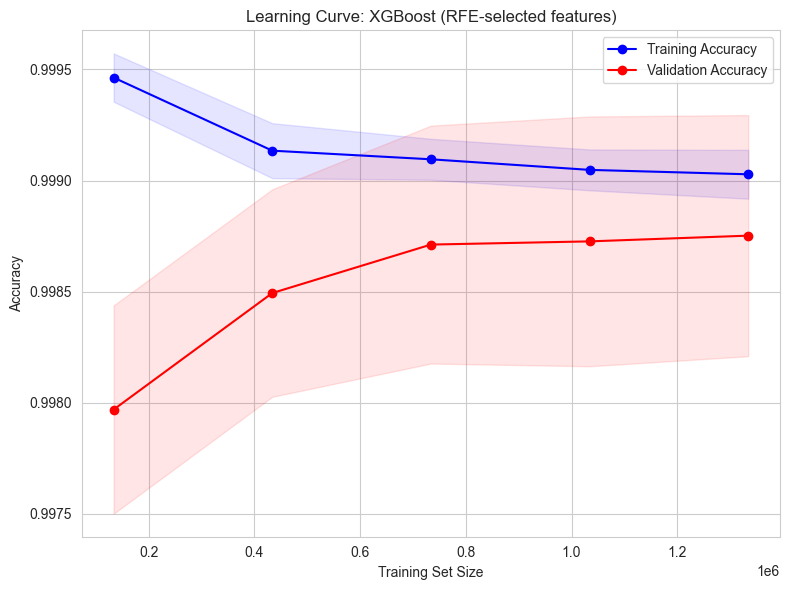


================= RANDOM FOREST PIPELINE =================


[DEBUG] Starting RFE fit (RandomForest) on TRAIN ONLY... (this may take a while)
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.

[DEBUG] RandomForest RFE Feature Ranking Results:
0: amt | Support=True, Rank=1
1: distance_km | Support=False, Rank=3
2: age | Support=True, Rank=1
3: city_pop | Support=True, Rank=1
4: year | Support=False, Rank=4
5: month | Support=True, Rank=1
6: hour | Support=True, Rank=1
7: day_of_week | Support=True, Rank=1
8: gender_M | Support=False, Rank=2
9: city_te | Support=True, Rank=1
10: state_te | Support=True, Rank=1
11: job_te | Support=True, Rank=1
12: category_te | Support=True, Rank=1

=== SELECTED FEATURES by RandomForest RFE ===
   - amt
   - age
   - city_pop
   - month
   - hour
   - day_of_week
   - city_te
   - state_te
   - job_te
   - category_te

[DEBUG] Training final RandomForest on selected features (TRAIN ONLY)...

=== 

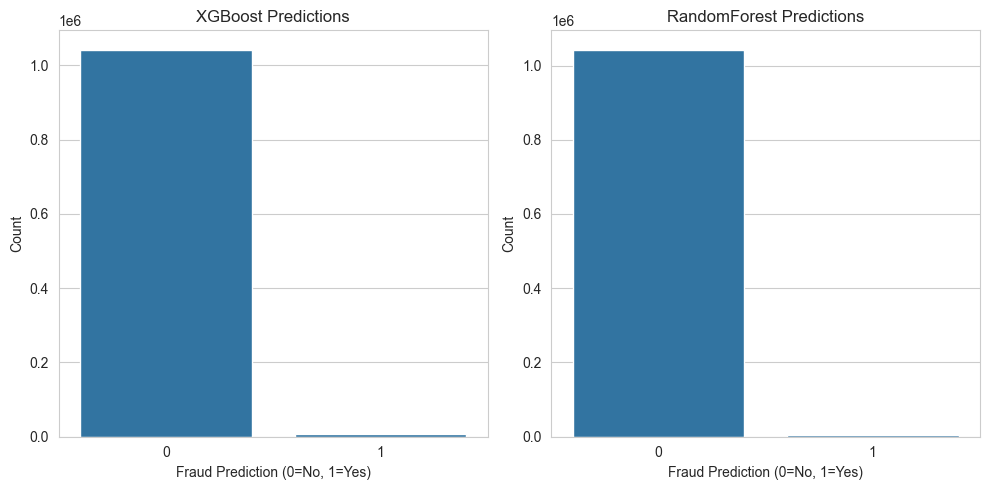

/var/folders/z9/cvzm0bkn2gv0qywmh29rgvrr0000gn/T/ipykernel_93601/3873473067.py:445: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="agreement", data=comp_df, ax=ax, palette="Set2")


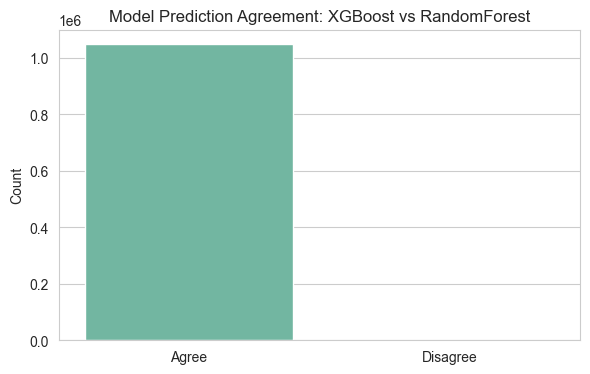


[INFO] Done! We have comp_df with columns 'xgb_pred' and 'rf_pred' for the entire dataset, plus some neat plots.


In [12]:
# -----------------------------------------------------------
# 1) IMPORTS & SETUP
# -----------------------------------------------------------
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Sklearn / ML
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# XGBoost (CPU-based)
import xgboost as xgb

# RandomForest
from sklearn.ensemble import RandomForestClassifier

# Advanced encoding for high-cardinality or single-col cat
from category_encoders import TargetEncoder

# For synthetic sampling (SMOTE)
from imblearn.over_sampling import SMOTE

# Optional progress bar
from tqdm import tqdm

sns.set_style("whitegrid")

# -----------------------------------------------------------
# 2) CREATE A COPY OF DF -> comp_df AND SPLIT INTO TRAIN/VAL/TEST
# -----------------------------------------------------------
"""
We assume your original DataFrame is named 'df' and has columns:
   'category','amt','gender','city','state','city_pop','job',
   'is_fraud','age','year','month','hour','day_of_week','distance_km',
   etc. (adjust as needed).

We will:
   1) Make a copy: comp_df = df.copy()
   2) Use comp_df in all subsequent transformations and modeling.
"""

# 2.1) Copy the original DataFrame
comp_df = df.copy()

# 2.2) Define the columns we actually need
useful_cols = [
    "category", "amt", "gender", "city", "state", "city_pop", "job",
    "is_fraud", "age", "year", "month", "hour", "day_of_week", 
    "distance_km"
]

# 2.3) Clean: drop rows with missing data (if any)
comp_df.dropna(subset=useful_cols, inplace=True)

# 2.4) X / y
X = comp_df.drop(columns=["is_fraud"])
y = comp_df["is_fraud"].astype(int)

print("Initial shape of X:", X.shape)
print("Initial shape of y:", y.shape)
print("Class distribution:\n", y.value_counts(normalize=True)*100, "%")

# Split: 80% Train / 20% Temp
X_train_temp, X_temp, y_train_temp, y_temp = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# From the 20% Temp, split 50/50 => 10% Validation, 10% Test (of original data)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_temp
)

print("\n=== FINAL SPLITS ===")
print("Train shape:", X_train_temp.shape, y_train_temp.shape)
print("Validation shape:", X_val.shape, y_val.shape)
print("Test shape:", X_test.shape, y_test.shape)

print("\nTrain class distribution:\n", y_train_temp.value_counts(normalize=True)*100, "%")
print("Val class distribution:\n", y_val.value_counts(normalize=True)*100, "%")
print("Test class distribution:\n", y_test.value_counts(normalize=True)*100, "%")

# -----------------------------------------------------------
# 3) COLUMN GROUPS FOR ENCODING
# -----------------------------------------------------------
numeric_features = [
    "amt", "distance_km", "age", "city_pop", 
    "year", "month", "hour", "day_of_week"
]
cat_small = ["gender"]                         # one-hot
cat_high  = ["city","state","job","category"]  # target-encode

# -----------------------------------------------------------
# 4) COLUMNTRANSFORMER (SCALING + ENCODING)
# -----------------------------------------------------------
numeric_transformer = Pipeline([
    ("scaler", StandardScaler())
])

ohe_transformer = Pipeline([
    ("ohe", OneHotEncoder(drop='first', handle_unknown='ignore'))
])

target_encoder = Pipeline([
    ("target_enc", TargetEncoder(smoothing=0.3))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("ohe", ohe_transformer, cat_small),
        ("te",  target_encoder,  cat_high),
    ],
    remainder="drop"
)

# -----------------------------------------------------------
# 5) FIT PREPROCESSOR & APPLY SMOTE (TRAIN ONLY)
# -----------------------------------------------------------
X_train_enc = preprocessor.fit_transform(X_train_temp, y_train_temp)
print("\n[INFO] Shape of X_train_enc BEFORE SMOTE:", X_train_enc.shape)
print("Class distribution in y_train_temp BEFORE SMOTE:", np.bincount(y_train_temp))

sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train_enc, y_train_temp)

print("\n[INFO] Shape of X_train_enc AFTER SMOTE:", X_train_sm.shape)
print("Class distribution in y_train_sm AFTER SMOTE:", np.bincount(y_train_sm))

# Encode validation & test sets (do NOT refit)
X_val_enc  = preprocessor.transform(X_val)
X_test_enc = preprocessor.transform(X_test)

# Build final feature name list
ohe_step = preprocessor.named_transformers_['ohe'].named_steps['ohe']
ohe_feature_names = ohe_step.get_feature_names_out(cat_small)
te_cols = [f"{col}_te" for col in cat_high]
final_feature_names = numeric_features + list(ohe_feature_names) + te_cols

print("\n[DEBUG] Final Encoded Feature List (Train/Val/Test share):")
print(final_feature_names)

# ===========================================================
# PART A: XGBOOST 
# ===========================================================
print("\n==================== XGBOOST PIPELINE ====================\n")

# -----------------------------------------------------------
# A.1) RFE USING XGBoost ON TRAIN
# -----------------------------------------------------------
xgb_clf = xgb.XGBClassifier(
    n_estimators=100,
    random_state=42,
    verbosity=1,
    tree_method='hist'
)

xgb_rfe = RFE(
    estimator=xgb_clf,
    n_features_to_select=10,
    step=1,
    verbose=1
)

print("\n[DEBUG] Starting RFE fit (XGBoost) on TRAIN ONLY... (this may take a while)")
xgb_rfe.fit(X_train_sm, y_train_sm)

xgb_support_mask = xgb_rfe.support_
xgb_ranking = xgb_rfe.ranking_

print("\n[DEBUG] XGBoost RFE Feature Ranking Results:")
for i, feat_name in enumerate(final_feature_names):
    print(f"{i}: {feat_name} | Support={xgb_support_mask[i]}, Rank={xgb_ranking[i]}")

xgb_selected_features = [f for f, s in zip(final_feature_names, xgb_support_mask) if s]
print("\n=== SELECTED FEATURES by XGBoost RFE ===")
for feat in xgb_selected_features:
    print("   -", feat)

X_train_sel_xgb = xgb_rfe.transform(X_train_sm)
X_val_sel_xgb   = xgb_rfe.transform(X_val_enc)
X_test_sel_xgb  = xgb_rfe.transform(X_test_enc)

# -----------------------------------------------------------
# A.2) TRAIN FINAL XGBOOST ON SELECTED FEATURES (TRAIN ONLY)
# -----------------------------------------------------------
final_xgb = xgb.XGBClassifier(
    n_estimators=100,
    random_state=42,
    verbosity=1,
    tree_method='hist'
)

print("\n[DEBUG] Training final XGBoost on selected features (TRAIN ONLY)...")
final_xgb.fit(X_train_sel_xgb, y_train_sm)

# -----------------------------------------------------------
# A.3) EVALUATE ON TRAIN SET FIRST (OVERFITTING CHECK)
# -----------------------------------------------------------
xgb_train_pred = final_xgb.predict(X_train_sel_xgb)
xgb_train_acc  = accuracy_score(y_train_sm, xgb_train_pred)

print("\n=== [XGBoost] MODEL PERFORMANCE ON TRAIN SET (WITH SMOTE) ===")
print("Accuracy (Train):", xgb_train_acc)
print("Classification Report (Train):\n", classification_report(y_train_sm, xgb_train_pred))
print("Confusion Matrix (Train):\n", confusion_matrix(y_train_sm, xgb_train_pred))

# -----------------------------------------------------------
# A.4) EVALUATE ON VALIDATION SET
# -----------------------------------------------------------
xgb_val_pred = final_xgb.predict(X_val_sel_xgb)
xgb_val_acc = accuracy_score(y_val, xgb_val_pred)

print("\n=== [XGBoost] MODEL PERFORMANCE ON VALIDATION SET ===")
print("Accuracy (Val):", xgb_val_acc)
print("Classification Report (Val):\n", classification_report(y_val, xgb_val_pred))
print("Confusion Matrix (Val):\n", confusion_matrix(y_val, xgb_val_pred))

# Decide if we want to proceed to the test set:
XGB_VAL_THRESHOLD = 0.99  # Example threshold. Adjust as needed.

if xgb_val_acc < XGB_VAL_THRESHOLD:
    print(f"\n[WARNING] [XGBoost] Validation Accuracy {xgb_val_acc:.4f} < {XGB_VAL_THRESHOLD}.")
    print("We are NOT satisfied. You may want to tweak hyperparameters, features, etc.")
    print("Skipping test evaluation for XGBoost.\n")
else:
    # -----------------------------------------------------------
    # A.5) EVALUATE ON TEST SET IF VALIDATION IS GOOD
    # -----------------------------------------------------------
    xgb_test_pred = final_xgb.predict(X_test_sel_xgb)
    xgb_test_acc = accuracy_score(y_test, xgb_test_pred)
    print("\n=== [XGBoost] MODEL PERFORMANCE ON TEST SET ===")
    print("Accuracy (Test):", xgb_test_acc)
    print("Classification Report (Test):\n", classification_report(y_test, xgb_test_pred))
    print("Confusion Matrix (Test):\n", confusion_matrix(y_test, xgb_test_pred))

# -----------------------------------------------------------
# A.6) OPTIONAL: PLOT LEARNING CURVE FOR XGBOOST
# -----------------------------------------------------------
train_sizes, train_scores, val_scores = learning_curve(
    final_xgb,
    X_train_sel_xgb,
    y_train_sm,
    cv=5,
    n_jobs=-1,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 5),
    shuffle=True,
    random_state=42
)

train_means = np.mean(train_scores, axis=1)
train_stds  = np.std(train_scores, axis=1)
val_means   = np.mean(val_scores, axis=1)
val_stds    = np.std(val_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_means, 'o-', color='blue', label='Training Accuracy')
plt.fill_between(train_sizes, train_means - train_stds, train_means + train_stds,
                 alpha=0.1, color='blue')

plt.plot(train_sizes, val_means, 'o-', color='red', label='Validation Accuracy')
plt.fill_between(train_sizes, val_means - val_stds, val_means + val_stds,
                 alpha=0.1, color='red')

plt.title('Learning Curve: XGBoost (RFE-selected features)')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# ===========================================================
# PART B: RANDOM FOREST (for comparison)
# ===========================================================
print("\n================= RANDOM FOREST PIPELINE =================\n")

# -----------------------------------------------------------
# B.1) RFE USING RANDOMFOREST ON TRAIN
# -----------------------------------------------------------
rf_clf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1  # parallel
)

rf_rfe = RFE(
    estimator=rf_clf,
    n_features_to_select=10,
    step=1,
    verbose=1
)

print("\n[DEBUG] Starting RFE fit (RandomForest) on TRAIN ONLY... (this may take a while)")
rf_rfe.fit(X_train_sm, y_train_sm)

rf_support_mask = rf_rfe.support_
rf_ranking = rf_rfe.ranking_

print("\n[DEBUG] RandomForest RFE Feature Ranking Results:")
for i, feat_name in enumerate(final_feature_names):
    print(f"{i}: {feat_name} | Support={rf_support_mask[i]}, Rank={rf_ranking[i]}")

rf_selected_features = [f for f, s in zip(final_feature_names, rf_support_mask) if s]
print("\n=== SELECTED FEATURES by RandomForest RFE ===")
for feat in rf_selected_features:
    print("   -", feat)

X_train_sel_rf = rf_rfe.transform(X_train_sm)
X_val_sel_rf   = rf_rfe.transform(X_val_enc)
X_test_sel_rf  = rf_rfe.transform(X_test_enc)

# -----------------------------------------------------------
# B.2) TRAIN FINAL RANDOMFOREST ON SELECTED FEATURES (TRAIN ONLY)
# -----------------------------------------------------------
final_rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

print("\n[DEBUG] Training final RandomForest on selected features (TRAIN ONLY)...")
final_rf.fit(X_train_sel_rf, y_train_sm)

# -----------------------------------------------------------
# B.3) EVALUATE ON TRAIN SET FIRST (OVERFITTING CHECK)
# -----------------------------------------------------------
rf_train_pred = final_rf.predict(X_train_sel_rf)
rf_train_acc  = accuracy_score(y_train_sm, rf_train_pred)

print("\n=== [RandomForest] MODEL PERFORMANCE ON TRAIN SET (WITH SMOTE) ===")
print("Accuracy (Train):", rf_train_acc)
print("Classification Report (Train):\n", classification_report(y_train_sm, rf_train_pred))
print("Confusion Matrix (Train):\n", confusion_matrix(y_train_sm, rf_train_pred))

# -----------------------------------------------------------
# B.4) EVALUATE ON VALIDATION SET
# -----------------------------------------------------------
rf_val_pred = final_rf.predict(X_val_sel_rf)
rf_val_acc = accuracy_score(y_val, rf_val_pred)

print("\n=== [RandomForest] MODEL PERFORMANCE ON VALIDATION SET ===")
print("Accuracy (Val):", rf_val_acc)
print("Classification Report (Val):\n", classification_report(y_val, rf_val_pred))
print("Confusion Matrix (Val):\n", confusion_matrix(y_val, rf_val_pred))

# Decide if we want to proceed to the test set:
RF_VAL_THRESHOLD = 0.99  # Example threshold. Adjust as needed.

if rf_val_acc < RF_VAL_THRESHOLD:
    print(f"\n[WARNING] [RandomForest] Validation Accuracy {rf_val_acc:.4f} < {RF_VAL_THRESHOLD}.")
    print("We are NOT satisfied. Consider tuning hyperparameters, features, etc.")
    print("Skipping test evaluation for RandomForest.\n")
else:
    # -----------------------------------------------------------
    # B.5) EVALUATE ON TEST SET IF VALIDATION IS GOOD
    # -----------------------------------------------------------
    rf_test_pred = final_rf.predict(X_test_sel_rf)
    rf_test_acc = accuracy_score(y_test, rf_test_pred)
    print("\n=== [RandomForest] MODEL PERFORMANCE ON TEST SET ===")
    print("Accuracy (Test):", rf_test_acc)
    print("Classification Report (Test):\n", classification_report(y_test, rf_test_pred))
    print("Confusion Matrix (Test):\n", confusion_matrix(y_test, rf_test_pred))

# -----------------------------------------------------------
# PART C: ADD PREDICTIONS TO comp_df & PLOT COMPARISONS
# -----------------------------------------------------------
"""
Now that both models are trained, let's apply them to the *entire dataset*
(i.e., comp_df) to get predictions. Then we'll store those predictions 
as new columns in comp_df, so we can visually compare them.

We'll do the same EXACT preprocessing steps for comp_df (excluding target col),
but do *not* re-fit any transformer. We'll then transform, RFE transform, and predict.

We'll store:
   comp_df["xgb_pred"] = ...
   comp_df["rf_pred"] = ...
"""

# (C.1) Preprocessing entire comp_df
# We do NOT include "is_fraud" in X_full since that's the target
X_full = comp_df.drop(columns=["is_fraud"])
X_full_enc = preprocessor.transform(X_full)

# (C.2) Transform with RFE
# For XGBoost, we used xgb_rfe. For RF, we used rf_rfe.
X_full_sel_xgb = xgb_rfe.transform(X_full_enc)
X_full_sel_rf  = rf_rfe.transform(X_full_enc)

# (C.3) Predict on the entire data
comp_df["xgb_pred"] = final_xgb.predict(X_full_sel_xgb)
comp_df["rf_pred"]  = final_rf.predict(X_full_sel_rf)

# Let's see the first 5 rows
print("\n[INFO] comp_df with predictions:")
print(comp_df.head())

# (C.4) Let's do some simple plotting to compare the 2 model predictions
"""
Example: 
 - We'll do a side-by-side bar chart of how many samples each model labeled as '1' (fraud).
 - We'll also create a countplot for each of the new columns ('xgb_pred', 'rf_pred').
"""

# Count how many 1's each model predicted
xgb_fraud_count = (comp_df["xgb_pred"] == 1).sum()
rf_fraud_count  = (comp_df["rf_pred"] == 1).sum()
total_count     = len(comp_df)

print(f"\nXGBoost predicted FRAUD=1 in {xgb_fraud_count} out of {total_count} rows.")
print(f"RandomForest predicted FRAUD=1 in {rf_fraud_count} out of {total_count} rows.")

# We'll plot side-by-side bar charts for a quick comparison:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.countplot(x="xgb_pred", data=comp_df, ax=axes[0])
axes[0].set_title("XGBoost Predictions")
axes[0].set_xlabel("Fraud Prediction (0=No, 1=Yes)")
axes[0].set_ylabel("Count")

sns.countplot(x="rf_pred", data=comp_df, ax=axes[1])
axes[1].set_title("RandomForest Predictions")
axes[1].set_xlabel("Fraud Prediction (0=No, 1=Yes)")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

# Another comparison: how often they agree vs disagree
comp_df["agreement"] = (comp_df["xgb_pred"] == comp_df["rf_pred"]).map({True: "Agree", False: "Disagree"})

fig, ax = plt.subplots(figsize=(6,4))
sns.countplot(x="agreement", data=comp_df, ax=ax, palette="Set2")
ax.set_title("Model Prediction Agreement: XGBoost vs RandomForest")
ax.set_xlabel("")
ax.set_ylabel("Count")
plt.tight_layout()
plt.show()

print("\n[INFO] Done! We have comp_df with columns 'xgb_pred' and 'rf_pred' for the entire dataset, plus some neat plots.")


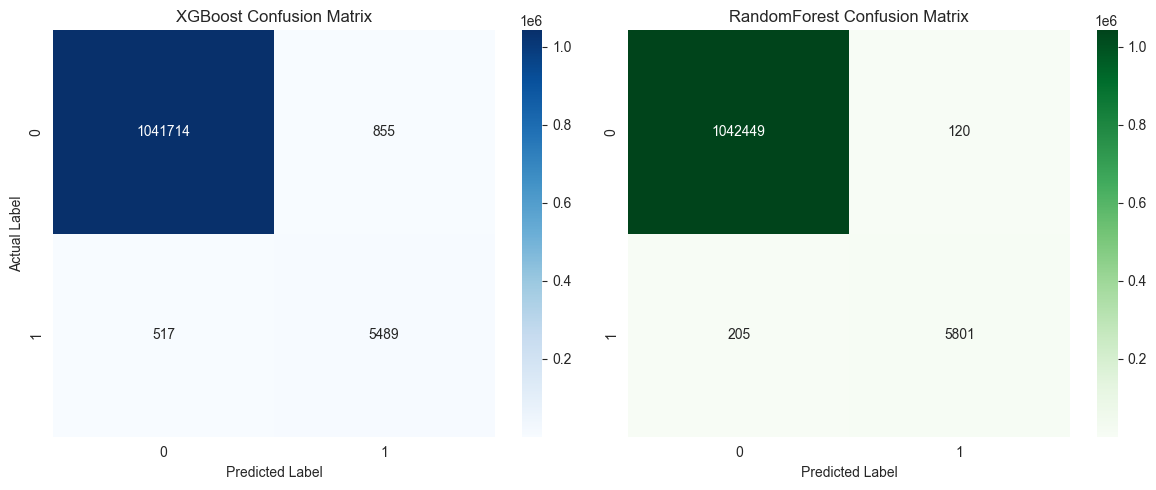

=== Classification Report: XGBoost (Entire Dataset) ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1042569
           1       0.87      0.91      0.89      6006

    accuracy                           1.00   1048575
   macro avg       0.93      0.96      0.94   1048575
weighted avg       1.00      1.00      1.00   1048575

=== Classification Report: RandomForest (Entire Dataset) ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1042569
           1       0.98      0.97      0.97      6006

    accuracy                           1.00   1048575
   macro avg       0.99      0.98      0.99   1048575
weighted avg       1.00      1.00      1.00   1048575


=== Crosstab: XGBoost Predictions vs Actual ===
Predicted        0     1
Actual                  
0          1041714   855
1              517  5489

=== Crosstab: RandomForest Predictions vs Actual ===
Predicted        0     1
A

/var/folders/z9/cvzm0bkn2gv0qywmh29rgvrr0000gn/T/ipykernel_93601/321599215.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="is_fraud", data=comp_df, ax=axes[0], palette="Set1")
/var/folders/z9/cvzm0bkn2gv0qywmh29rgvrr0000gn/T/ipykernel_93601/321599215.py:80: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="xgb_pred", data=comp_df, ax=axes[1], palette="Set2")
/var/folders/z9/cvzm0bkn2gv0qywmh29rgvrr0000gn/T/ipykernel_93601/321599215.py:92: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="rf_pred", data=comp_df, ax=axes[2], palett

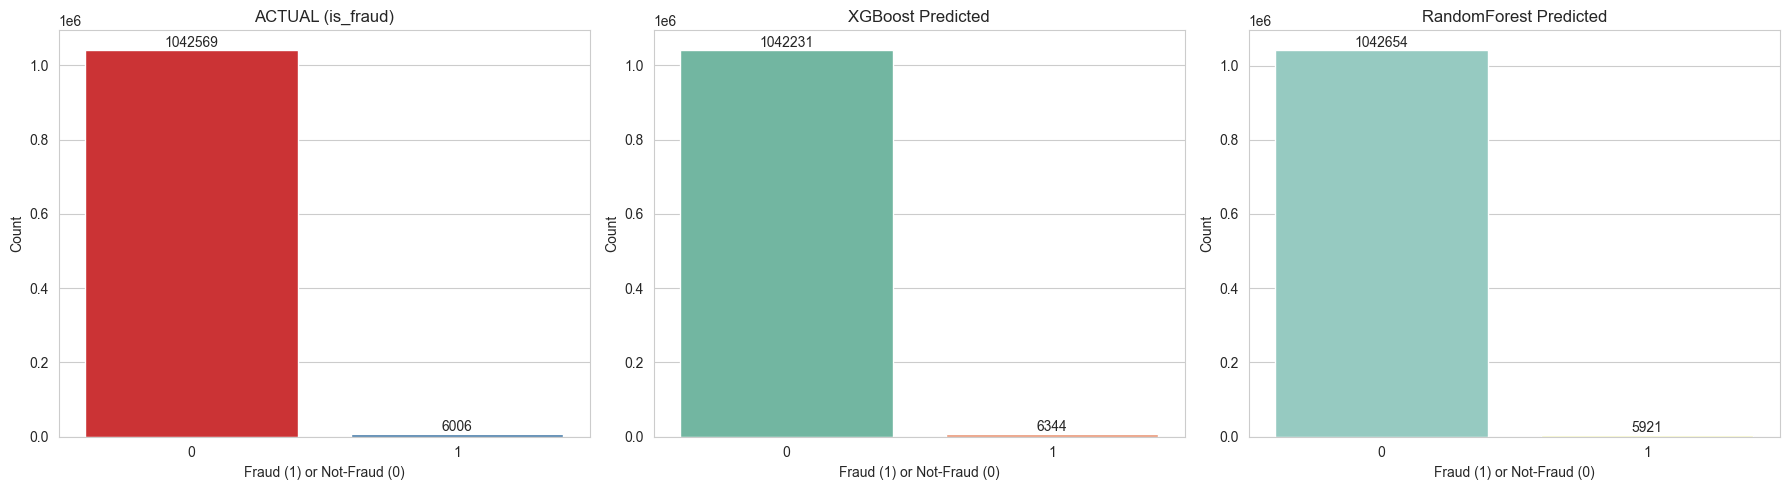

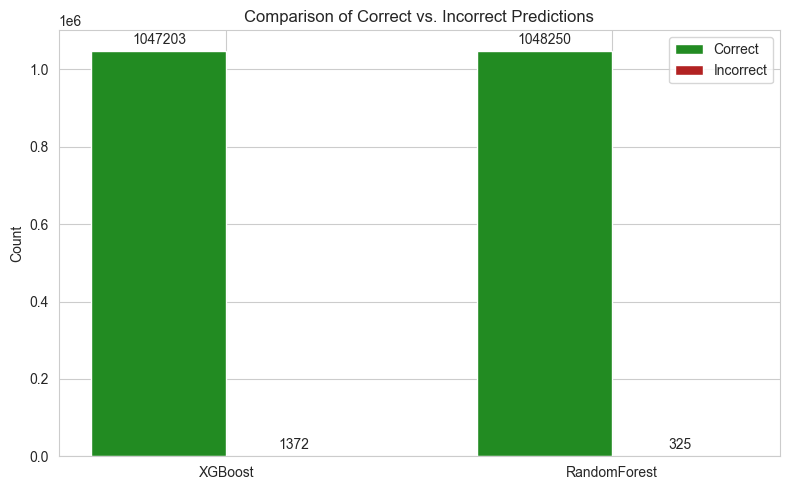


[INFO] Additional plots and evaluation metrics have been displayed. Enjoy!


In [13]:
# =============================================================================
# CONTINUATION: ADDITIONAL PLOTS & EVALUATIONS FOR XGBOOST VS RANDOM FOREST
# =============================================================================
"""
Below code assumes 'comp_df' already has columns:
    - 'is_fraud'  (actual)
    - 'xgb_pred'  (XGBoost predicted label)
    - 'rf_pred'   (RandomForest predicted label)

and that the necessary libraries (pandas, seaborn, matplotlib, sklearn, etc.)
are already imported in the environment.
"""
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# 1) CONFUSION MATRICES (HEATMAPS) FOR BOTH MODELS
# ------------------------------------------------
cm_xgb = confusion_matrix(comp_df["is_fraud"], comp_df["xgb_pred"])
cm_rf  = confusion_matrix(comp_df["is_fraud"], comp_df["rf_pred"])

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("XGBoost Confusion Matrix")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("Actual Label")

sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Greens", ax=axes[1])
axes[1].set_title("RandomForest Confusion Matrix")
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()

# 2) PRINT CLASSIFICATION REPORTS FOR BOTH MODELS
# ------------------------------------------------
print("=== Classification Report: XGBoost (Entire Dataset) ===")
print(classification_report(comp_df["is_fraud"], comp_df["xgb_pred"]))

print("=== Classification Report: RandomForest (Entire Dataset) ===")
print(classification_report(comp_df["is_fraud"], comp_df["rf_pred"]))

# 3) CROSSTAB / CONTINGENCY TABLE (ACTUAL vs PREDICTED)
# -----------------------------------------------------
xgb_crosstab = pd.crosstab(
    comp_df["is_fraud"], comp_df["xgb_pred"], 
    rownames=["Actual"], colnames=["Predicted"]
)
rf_crosstab = pd.crosstab(
    comp_df["is_fraud"], comp_df["rf_pred"], 
    rownames=["Actual"], colnames=["Predicted"]
)

print("\n=== Crosstab: XGBoost Predictions vs Actual ===")
print(xgb_crosstab)
print("\n=== Crosstab: RandomForest Predictions vs Actual ===")
print(rf_crosstab)

# 4) BAR PLOT OF ACTUAL VS. PREDICTED FOR EACH MODEL
# --------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 4.1) Actual class distribution
sns.countplot(x="is_fraud", data=comp_df, ax=axes[0], palette="Set1")
axes[0].set_title("ACTUAL (is_fraud)")
axes[0].set_xlabel("Fraud (1) or Not-Fraud (0)")
axes[0].set_ylabel("Count")
for p in axes[0].patches:
    axes[0].annotate(
        int(p.get_height()), 
        (p.get_x() + p.get_width() / 2, p.get_height()), 
        ha='center', va='bottom'
    )

# 4.2) XGBoost predicted distribution
sns.countplot(x="xgb_pred", data=comp_df, ax=axes[1], palette="Set2")
axes[1].set_title("XGBoost Predicted")
axes[1].set_xlabel("Fraud (1) or Not-Fraud (0)")
axes[1].set_ylabel("Count")
for p in axes[1].patches:
    axes[1].annotate(
        int(p.get_height()), 
        (p.get_x() + p.get_width() / 2, p.get_height()), 
        ha='center', va='bottom'
    )

# 4.3) RandomForest predicted distribution
sns.countplot(x="rf_pred", data=comp_df, ax=axes[2], palette="Set3")
axes[2].set_title("RandomForest Predicted")
axes[2].set_xlabel("Fraud (1) or Not-Fraud (0)")
axes[2].set_ylabel("Count")
for p in axes[2].patches:
    axes[2].annotate(
        int(p.get_height()), 
        (p.get_x() + p.get_width() / 2, p.get_height()), 
        ha='center', va='bottom'
    )

plt.tight_layout()
plt.show()

# 5) COMPARISON OF CORRECT vs INCORRECT PREDICTIONS FOR EACH MODEL
# ----------------------------------------------------------------
comp_df["xgb_correct"] = (comp_df["xgb_pred"] == comp_df["is_fraud"]).map({True: 1, False: 0})
comp_df["rf_correct"]  = (comp_df["rf_pred"]  == comp_df["is_fraud"]).map({True: 1, False: 0})

xgb_correct_count = comp_df["xgb_correct"].sum()
rf_correct_count  = comp_df["rf_correct"].sum()
total_samples     = len(comp_df)

labels = ["XGBoost", "RandomForest"]
correct_vals = [xgb_correct_count, rf_correct_count]
incorrect_vals = [(total_samples - xgb_correct_count), (total_samples - rf_correct_count)]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))

bar1 = ax.bar(x - width/2, correct_vals, width, label='Correct', color="forestgreen")
bar2 = ax.bar(x + width/2, incorrect_vals, width, label='Incorrect', color="firebrick")

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel("Count")
ax.set_title("Comparison of Correct vs. Incorrect Predictions")
ax.legend()

for bars in (bar1, bar2):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(
            f'{height}',
            xy=(bar.get_x() + bar.get_width()/2, height),
            xytext=(0, 3),
            textcoords="offset points",
            ha='center', 
            va='bottom'
        )

plt.tight_layout()
plt.show()

print("\n[INFO] Additional plots and evaluation metrics have been displayed. Enjoy!")


In [14]:
#predict the fpr -false positive rate - fewer false alarms - more accurate
# ppv precision - fewer false positives - more accurate
# fdr - false discovery rate - fewer false positives - more accurate
#specificity - fewer false negatives - more accurate (fewer false positives)
#research on thresholding 

In [15]:
###############################################################################
# EXPLANATION OF ACCURACY
###############################################################################
"""
Accuracy typically means:
   accuracy = (Number of Correct Predictions) / (Total Predictions)

When you see:
   accuracy_score(y_test, y_pred_test)
it means "the fraction of samples in the test set for which the predicted label
matches the true label."

Similarly, for the entire dataset (e.g., comp_df), if we have:
   accuracy_score(comp_df['is_fraud'], comp_df['xgb_pred'])
that is "the fraction of all rows in comp_df for which XGBoost predicted
the label correctly."

Below, we demonstrate how to:
1) Print the Train/Val/Test set accuracies for each model (XGBoost & RandomForest).
2) If you've already stored predictions for the entire dataset (comp_df),
   compute overall accuracy & error metrics on the entire dataset, for each model.
"""

###############################################################################
# 1) ACCURACY ON TRAIN / VALIDATION / TEST SETS
###############################################################################
# Suppose you already have:
#   - X_train_sel_xgb, y_train_sm  (Training set features + labels)
#   - X_val_sel_xgb,   y_val       (Validation set features + labels)
#   - X_test_sel_xgb,  y_test      (Test set features + labels)
#   - final_xgb        (Trained XGBoost model)
#   - final_rf         (Trained RandomForest model)
#
# Similarly for the RandomForest transforms: X_train_sel_rf, X_val_sel_rf, X_test_sel_rf
from sklearn.metrics import accuracy_score

# ---- XGBoost
train_pred_xgb = final_xgb.predict(X_train_sel_xgb)
val_pred_xgb   = final_xgb.predict(X_val_sel_xgb)
test_pred_xgb  = final_xgb.predict(X_test_sel_xgb)

train_acc_xgb = accuracy_score(y_train_sm, train_pred_xgb)
val_acc_xgb   = accuracy_score(y_val, val_pred_xgb)
test_acc_xgb  = accuracy_score(y_test, test_pred_xgb)

print("=== XGBoost ACCURACY (by dataset) ===")
print(f"Train Accuracy: {train_acc_xgb:.4f} ({train_acc_xgb*100:.2f}%)")
print(f"Val Accuracy:   {val_acc_xgb:.4f} ({val_acc_xgb*100:.2f}%)")
print(f"Test Accuracy:  {test_acc_xgb:.4f} ({test_acc_xgb*100:.2f}%)\n")

# ---- RandomForest
train_pred_rf = final_rf.predict(X_train_sel_rf)
val_pred_rf   = final_rf.predict(X_val_sel_rf)
test_pred_rf  = final_rf.predict(X_test_sel_rf)

train_acc_rf = accuracy_score(y_train_sm, train_pred_rf)
val_acc_rf   = accuracy_score(y_val, val_pred_rf)
test_acc_rf  = accuracy_score(y_test, test_pred_rf)

print("=== RandomForest ACCURACY (by dataset) ===")
print(f"Train Accuracy: {train_acc_rf:.4f} ({train_acc_rf*100:.2f}%)")
print(f"Val Accuracy:   {val_acc_rf:.4f} ({val_acc_rf*100:.2f}%)")
print(f"Test Accuracy:  {test_acc_rf:.4f} ({test_acc_rf*100:.2f}%)\n")

###############################################################################
# 2) ACCURACY ON THE ENTIRE DATASET (comp_df)
###############################################################################
"""
In your flow, you created comp_df, then added columns:
   comp_df["xgb_pred"]
   comp_df["rf_pred"]
That means each row in comp_df now has:
   - is_fraud (actual label)
   - xgb_pred (XGBoost's predicted label)
   - rf_pred  (RandomForest's predicted label)
So we can measure overall accuracy across the entire dataset.
"""

# Example: XGBoost overall accuracy on comp_df
overall_acc_xgb = accuracy_score(comp_df["is_fraud"], comp_df["xgb_pred"])
# We can do the same for RandomForest
overall_acc_rf  = accuracy_score(comp_df["is_fraud"], comp_df["rf_pred"])

print("=== OVERALL ACCURACY (Entire comp_df) ===")
print(f"XGBoost overall:      {overall_acc_xgb:.4f} ({overall_acc_xgb*100:.2f}%)")
print(f"RandomForest overall: {overall_acc_rf:.4f} ({overall_acc_rf*100:.2f}%)\n")

###############################################################################
# 3) CORRECT VS. INCORRECT COUNTS + PERCENTAGES
###############################################################################
# For each model, let's see how many rows were correct vs. incorrect

total_rows = len(comp_df)

xgb_correct_count = (comp_df["xgb_pred"] == comp_df["is_fraud"]).sum()
xgb_incorrect_count = total_rows - xgb_correct_count
xgb_correct_pct = xgb_correct_count / total_rows * 100
xgb_incorrect_pct = 100 - xgb_correct_pct

rf_correct_count = (comp_df["rf_pred"] == comp_df["is_fraud"]).sum()
rf_incorrect_count = total_rows - rf_correct_count
rf_correct_pct = rf_correct_count / total_rows * 100
rf_incorrect_pct = 100 - rf_correct_pct

print("=== XGBoost: Correct vs. Incorrect on Entire Dataset ===")
print(f"Total samples:       {total_rows}")
print(f"Correct predictions: {xgb_correct_count} ({xgb_correct_pct:.2f}%)")
print(f"Incorrect preds:     {xgb_incorrect_count} ({xgb_incorrect_pct:.2f}%)\n")

print("=== RandomForest: Correct vs. Incorrect on Entire Dataset ===")
print(f"Total samples:       {total_rows}")
print(f"Correct predictions: {rf_correct_count} ({rf_correct_pct:.2f}%)")
print(f"Incorrect preds:     {rf_incorrect_count} ({rf_incorrect_pct:.2f}%)\n")

###############################################################################
# 4) (Optional) More Detailed Metrics
###############################################################################
from sklearn.metrics import precision_score, recall_score, f1_score

xgb_precision = precision_score(comp_df["is_fraud"], comp_df["xgb_pred"], zero_division=0)
xgb_recall    = recall_score(comp_df["is_fraud"], comp_df["xgb_pred"], zero_division=0)
xgb_f1        = f1_score(comp_df["is_fraud"], comp_df["xgb_pred"], zero_division=0)

rf_precision  = precision_score(comp_df["is_fraud"], comp_df["rf_pred"], zero_division=0)
rf_recall     = recall_score(comp_df["is_fraud"], comp_df["rf_pred"], zero_division=0)
rf_f1         = f1_score(comp_df["is_fraud"], comp_df["rf_pred"], zero_division=0)

print("=== Detailed Metrics: XGBoost (Entire comp_df) ===")
print(f"Precision: {xgb_precision:.4f}")
print(f"Recall:    {xgb_recall:.4f}")
print(f"F1 Score:  {xgb_f1:.4f}\n")

print("=== Detailed Metrics: RandomForest (Entire comp_df) ===")
print(f"Precision: {rf_precision:.4f}")
print(f"Recall:    {rf_recall:.4f}")
print(f"F1 Score:  {rf_f1:.4f}\n")

###############################################################################
# SUMMARY
###############################################################################
"""
- The calls to accuracy_score() in your code for 'Train Accuracy', 'Val Accuracy',
  and 'Test Accuracy' refer to how well the model performed on those splits. 
  So, "Accuracy (Val)" is the fraction of correct predictions on your validation set. 
  "Accuracy (Test)" is the fraction correct on your held-out test set. 

- When you do a final run on comp_df (with 'xgb_pred' or 'rf_pred' columns),
  you're computing the fraction of correct predictions across the *entire dataset* 
  (which might include train, val, and test data all together, if you used the entire df).

- The correct vs. incorrect counts show you how many were predicted correctly and incorrectly 
  out of the total rows. This is just another way of expressing overall accuracy, but 
  gives you raw counts and percentages.

- Detailed metrics (precision, recall, F1) can provide more insight if your data is imbalanced.
"""


=== XGBoost ACCURACY (by dataset) ===
Train Accuracy: 0.9989 (99.89%)
Val Accuracy:   0.9981 (99.81%)
Test Accuracy:  0.9983 (99.83%)

=== RandomForest ACCURACY (by dataset) ===
Train Accuracy: 1.0000 (100.00%)
Val Accuracy:   0.9983 (99.83%)
Test Accuracy:  0.9986 (99.86%)

=== OVERALL ACCURACY (Entire comp_df) ===
XGBoost overall:      0.9987 (99.87%)
RandomForest overall: 0.9997 (99.97%)

=== XGBoost: Correct vs. Incorrect on Entire Dataset ===
Total samples:       1048575
Correct predictions: 1047203 (99.87%)
Incorrect preds:     1372 (0.13%)

=== RandomForest: Correct vs. Incorrect on Entire Dataset ===
Total samples:       1048575
Correct predictions: 1048250 (99.97%)
Incorrect preds:     325 (0.03%)

=== Detailed Metrics: XGBoost (Entire comp_df) ===
Precision: 0.8652
Recall:    0.9139
F1 Score:  0.8889

=== Detailed Metrics: RandomForest (Entire comp_df) ===
Precision: 0.9797
Recall:    0.9659
F1 Score:  0.9728



'\n- The calls to accuracy_score() in your code for \'Train Accuracy\', \'Val Accuracy\',\n  and \'Test Accuracy\' refer to how well the model performed on those splits. \n  So, "Accuracy (Val)" is the fraction of correct predictions on your validation set. \n  "Accuracy (Test)" is the fraction correct on your held-out test set. \n\n- When you do a final run on comp_df (with \'xgb_pred\' or \'rf_pred\' columns),\n  you\'re computing the fraction of correct predictions across the *entire dataset* \n  (which might include train, val, and test data all together, if you used the entire df).\n\n- The correct vs. incorrect counts show you how many were predicted correctly and incorrectly \n  out of the total rows. This is just another way of expressing overall accuracy, but \n  gives you raw counts and percentages.\n\n- Detailed metrics (precision, recall, F1) can provide more insight if your data is imbalanced.\n'

Overfitting checks:

Initial shape of X: (1048575, 24)
Initial shape of y: (1048575,)
Class distribution:
 is_fraud
0    99.427223
1     0.572777
Name: proportion, dtype: float64 %

=== FINAL SPLITS ===
Train shape: (838860, 24) (838860,)
Validation shape: (104857, 24) (104857,)
Test shape: (104858, 24) (104858,)

Train class distribution:
 is_fraud
0    99.427199
1     0.572801
Name: proportion, dtype: float64 %
Val class distribution:
 is_fraud
0    99.427792
1     0.572208
Name: proportion, dtype: float64 %
Test class distribution:
 is_fraud
0    99.426844
1     0.573156
Name: proportion, dtype: float64 %

[INFO] Shape of X_train_enc BEFORE SMOTE: (838860, 13)
Class distribution in y_train_temp BEFORE SMOTE: [834055   4805]

[INFO] Shape of X_train_enc AFTER SMOTE: (1668110, 13)
Class distribution in y_train_sm AFTER SMOTE: [834055 834055]

[DEBUG] Final Encoded Feature List (Train/Val/Test share):
['amt', 'distance_km', 'age', 'city_pop', 'year', 'month', 'hour', 'day_of_week', 'gender_M', 'city_te', '

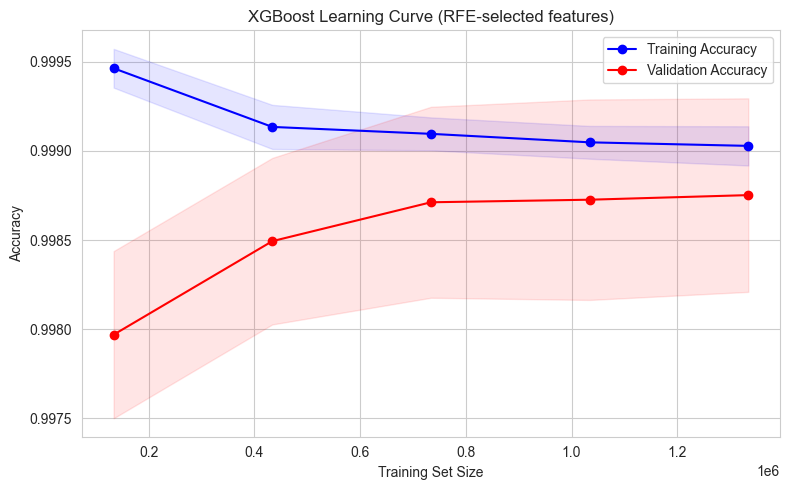


================= RANDOM FOREST PIPELINE =================


[DEBUG] Starting RFE fit (RandomForest) on TRAIN ONLY... (this may take a while)
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.

[DEBUG] RandomForest RFE Feature Ranking Results:
0: amt | Selected=True, Rank=1
1: distance_km | Selected=False, Rank=3
2: age | Selected=True, Rank=1
3: city_pop | Selected=True, Rank=1
4: year | Selected=False, Rank=4
5: month | Selected=True, Rank=1
6: hour | Selected=True, Rank=1
7: day_of_week | Selected=True, Rank=1
8: gender_M | Selected=False, Rank=2
9: city_te | Selected=True, Rank=1
10: state_te | Selected=True, Rank=1
11: job_te | Selected=True, Rank=1
12: category_te | Selected=True, Rank=1

=== SELECTED FEATURES by RandomForest RFE ===
   - amt
   - age
   - city_pop
   - month
   - hour
   - day_of_week
   - city_te
   - state_te
   - job_te
   - category_te

[DEBUG] Training final RandomForest on selected features (TRAIN O

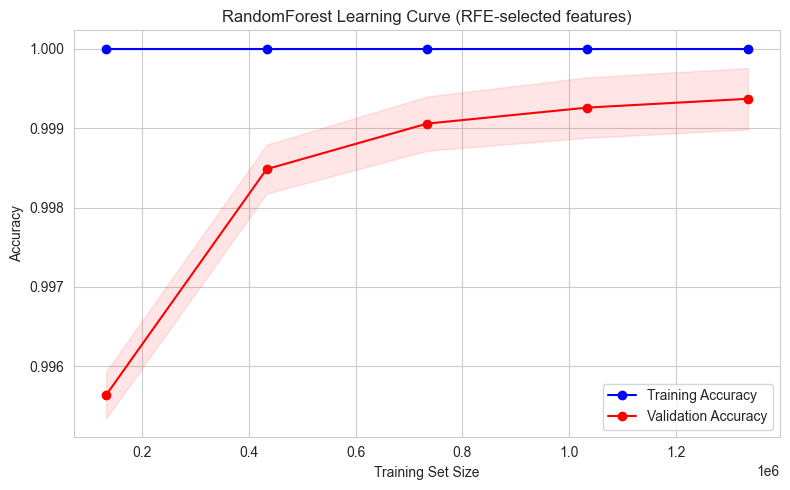


[INFO] comp_df with predictions (first 5 rows):
         cc_num                            merchant       category     amt  \
0  2.703190e+15          fraud_Rippin, Kub and Mann       misc_net    4.97   
1  6.304230e+11     fraud_Heller, Gutmann and Zieme    grocery_pos  107.23   
2  3.885950e+13                fraud_Lind-Buckridge  entertainment  220.11   
3  3.534090e+15  fraud_Kutch, Hermiston and Farrell  gas_transport   45.00   
4  3.755340e+14                 fraud_Keeling-Crist       misc_pos   41.96   

  gender                        street            city state    zip      lat  \
0      F                561 Perry Cove  Moravian Falls    NC  28654  36.0788   
1      F  43039 Riley Greens Suite 393          Orient    WA  99160  48.8878   
2      M      594 White Dale Suite 530      Malad City    ID  83252  42.1808   
3      M   9443 Cynthia Court Apt. 038         Boulder    MT  59632  46.2306   
4      M              408 Bradley Rest        Doe Hill    VA  24433  38.4207   

 

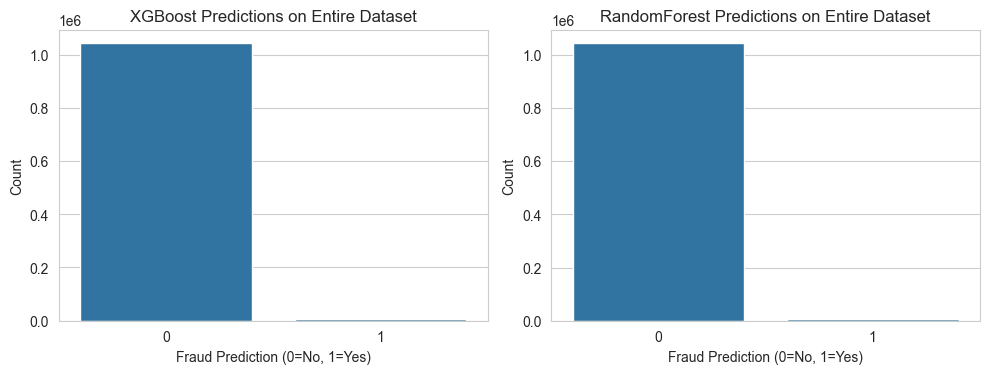

/var/folders/z9/cvzm0bkn2gv0qywmh29rgvrr0000gn/T/ipykernel_93601/2671222498.py:452: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.countplot(x="agreement", data=comp_df, ax=ax, palette="Set2")


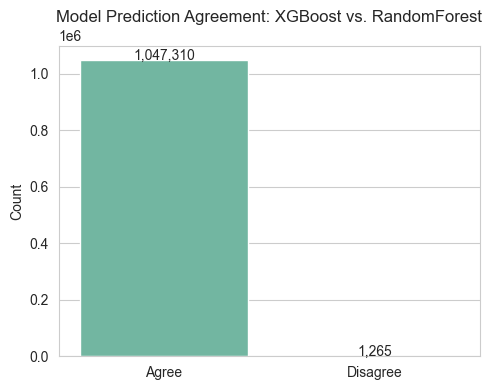


Exact Agreement Counts:
agreement
Agree       1047310
Disagree       1265
Name: count, dtype: int64

[INFO] Done! We have added train/val/test checks, learning curves, and final predictions on entire dataset with visual comparisons.


In [16]:
###############################################################################
# EDITED CODE WITH OVERFITTING CHECKS & PLOTS
###############################################################################
"""
This version includes:
1) Train/Val/Test accuracy checks for both XGBoost and RandomForest
2) Learning Curves for both models to visualize potential overfitting
3) The usual final predictions on the entire dataset (comp_df) for comparison
"""

# -----------------------------------------------------------
# 1) IMPORTS & SETUP
# -----------------------------------------------------------
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Sklearn / ML
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# XGBoost (CPU-based)
import xgboost as xgb

# RandomForest
from sklearn.ensemble import RandomForestClassifier

# Advanced encoding for high-cardinality or single-col cat
from category_encoders import TargetEncoder

# For synthetic sampling (SMOTE)
from imblearn.over_sampling import SMOTE

# Optional progress bar
from tqdm import tqdm

sns.set_style("whitegrid")

###############################################################################
# 2) CREATE A COPY OF DF -> comp_df AND SPLIT INTO TRAIN/VAL/TEST
###############################################################################
"""
We assume your original DataFrame is named 'df' and has columns:
   'category','amt','gender','city','state','city_pop','job',
   'is_fraud','age','year','month','hour','day_of_week','distance_km',
   etc. (adjust as needed).

Steps:
   1) Make a copy: comp_df = df.copy()
   2) Use comp_df in all transformations, modeling, final predictions.
"""

# 2.1) Copy the original DataFrame
comp_df = df.copy()

# 2.2) Define the columns we actually need
useful_cols = [
    "category", "amt", "gender", "city", "state", "city_pop", "job",
    "is_fraud", "age", "year", "month", "hour", "day_of_week", 
    "distance_km"
]

# 2.3) Clean: drop rows with missing data (if any)
comp_df.dropna(subset=useful_cols, inplace=True)

# 2.4) X / y
X = comp_df.drop(columns=["is_fraud"])
y = comp_df["is_fraud"].astype(int)

print("Initial shape of X:", X.shape)
print("Initial shape of y:", y.shape)
print("Class distribution:\n", y.value_counts(normalize=True)*100, "%")

# Split: 80% Train / 20% Temp
X_train_temp, X_temp, y_train_temp, y_temp = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# From the 20% Temp, split 50/50 => 10% Validation, 10% Test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_temp
)

print("\n=== FINAL SPLITS ===")
print("Train shape:", X_train_temp.shape, y_train_temp.shape)
print("Validation shape:", X_val.shape, y_val.shape)
print("Test shape:", X_test.shape, y_test.shape)

print("\nTrain class distribution:\n", y_train_temp.value_counts(normalize=True)*100, "%")
print("Val class distribution:\n", y_val.value_counts(normalize=True)*100, "%")
print("Test class distribution:\n", y_test.value_counts(normalize=True)*100, "%")

###############################################################################
# 3) COLUMN GROUPS FOR ENCODING
###############################################################################
numeric_features = [
    "amt", "distance_km", "age", "city_pop", 
    "year", "month", "hour", "day_of_week"
]
cat_small = ["gender"]                         # one-hot
cat_high  = ["city","state","job","category"]  # target-encode

###############################################################################
# 4) COLUMNTRANSFORMER (SCALING + ENCODING)
###############################################################################
numeric_transformer = Pipeline([
    ("scaler", StandardScaler())
])

ohe_transformer = Pipeline([
    ("ohe", OneHotEncoder(drop='first', handle_unknown='ignore'))
])

target_encoder = Pipeline([
    ("target_enc", TargetEncoder(smoothing=0.3))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("ohe", ohe_transformer, cat_small),
        ("te",  target_encoder,  cat_high),
    ],
    remainder="drop"
)

###############################################################################
# 5) FIT PREPROCESSOR & APPLY SMOTE (TRAIN ONLY)
###############################################################################
X_train_enc = preprocessor.fit_transform(X_train_temp, y_train_temp)
print("\n[INFO] Shape of X_train_enc BEFORE SMOTE:", X_train_enc.shape)
print("Class distribution in y_train_temp BEFORE SMOTE:", np.bincount(y_train_temp))

sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train_enc, y_train_temp)

print("\n[INFO] Shape of X_train_enc AFTER SMOTE:", X_train_sm.shape)
print("Class distribution in y_train_sm AFTER SMOTE:", np.bincount(y_train_sm))

# Encode validation & test sets (do NOT refit)
X_val_enc  = preprocessor.transform(X_val)
X_test_enc = preprocessor.transform(X_test)

# Build final feature name list (optional, for reference)
ohe_step = preprocessor.named_transformers_['ohe'].named_steps['ohe']
ohe_feature_names = ohe_step.get_feature_names_out(cat_small)
te_cols = [f"{col}_te" for col in cat_high]
final_feature_names = numeric_features + list(ohe_feature_names) + te_cols

print("\n[DEBUG] Final Encoded Feature List (Train/Val/Test share):")
print(final_feature_names)

###############################################################################
# PART A: XGBOOST 
###############################################################################
print("\n==================== XGBOOST PIPELINE ====================\n")

# -----------------------------------------------------------
# A.1) RFE USING XGBoost ON TRAIN
# -----------------------------------------------------------
xgb_clf = xgb.XGBClassifier(
    n_estimators=100,
    random_state=42,
    verbosity=1,
    tree_method='hist'
)

xgb_rfe = RFE(
    estimator=xgb_clf,
    n_features_to_select=10,
    step=1,
    verbose=1
)

print("\n[DEBUG] Starting RFE fit (XGBoost) on TRAIN ONLY... (this may take a while)")
xgb_rfe.fit(X_train_sm, y_train_sm)

xgb_support_mask = xgb_rfe.support_
xgb_ranking = xgb_rfe.ranking_
xgb_selected_features = [f for f, s in zip(final_feature_names, xgb_support_mask) if s]

print("\n[DEBUG] XGBoost RFE Feature Ranking Results:")
for i, feat in enumerate(final_feature_names):
    print(f"{i}: {feat} | Selected={xgb_support_mask[i]}, Rank={xgb_ranking[i]}")

print("\n=== SELECTED FEATURES by XGBoost RFE ===")
for feat in xgb_selected_features:
    print("   -", feat)

X_train_sel_xgb = xgb_rfe.transform(X_train_sm)
X_val_sel_xgb   = xgb_rfe.transform(X_val_enc)
X_test_sel_xgb  = xgb_rfe.transform(X_test_enc)

# -----------------------------------------------------------
# A.2) TRAIN FINAL XGBOOST ON SELECTED FEATURES (TRAIN ONLY)
# -----------------------------------------------------------
final_xgb = xgb.XGBClassifier(
    n_estimators=100,
    random_state=42,
    verbosity=1,
    tree_method='hist'
)

print("\n[DEBUG] Training final XGBoost on selected features (TRAIN ONLY)...")
final_xgb.fit(X_train_sel_xgb, y_train_sm)

# -----------------------------------------------------------
# A.3) EVALUATE ON TRAIN / VALIDATION / (OPTIONAL) TEST
# -----------------------------------------------------------
print("\n=== [XGBoost] EVALUATION ===")

xgb_train_pred = final_xgb.predict(X_train_sel_xgb)
xgb_train_acc  = accuracy_score(y_train_sm, xgb_train_pred)
print("Train Accuracy:", xgb_train_acc)
print("Train Classification Report:\n", classification_report(y_train_sm, xgb_train_pred))

xgb_val_pred = final_xgb.predict(X_val_sel_xgb)
xgb_val_acc = accuracy_score(y_val, xgb_val_pred)
print("\nVal Accuracy:", xgb_val_acc)
print("Val Classification Report:\n", classification_report(y_val, xgb_val_pred))

XGB_VAL_THRESHOLD = 0.99
if xgb_val_acc < XGB_VAL_THRESHOLD:
    print(f"\n[WARNING] [XGBoost] Validation Accuracy {xgb_val_acc:.4f} < {XGB_VAL_THRESHOLD}.")
    print("Skipping XGBoost test evaluation. (Can tune hyperparams, etc.)\n")
else:
    # If satisfied, evaluate on Test
    xgb_test_pred = final_xgb.predict(X_test_sel_xgb)
    xgb_test_acc = accuracy_score(y_test, xgb_test_pred)
    print("\nTest Accuracy:", xgb_test_acc)
    print("Test Classification Report:\n", classification_report(y_test, xgb_test_pred))

###############################################################################
# A.4) LEARNING CURVE FOR XGBOOST (Overfitting Check)
###############################################################################
train_sizes, train_scores, val_scores = learning_curve(
    final_xgb,
    X_train_sel_xgb,
    y_train_sm,
    cv=5,
    n_jobs=-1,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 5),
    shuffle=True,
    random_state=42
)

train_means = np.mean(train_scores, axis=1)
train_stds  = np.std(train_scores, axis=1)
val_means   = np.mean(val_scores, axis=1)
val_stds    = np.std(val_scores, axis=1)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_means, 'o-', color='blue', label='Training Accuracy')
plt.fill_between(train_sizes, train_means - train_stds, train_means + train_stds,
                 alpha=0.1, color='blue')

plt.plot(train_sizes, val_means, 'o-', color='red', label='Validation Accuracy')
plt.fill_between(train_sizes, val_means - val_stds, val_means + val_stds,
                 alpha=0.1, color='red')

plt.title('XGBoost Learning Curve (RFE-selected features)')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

###############################################################################
# PART B: RANDOM FOREST (Compare to XGBoost)
###############################################################################
print("\n================= RANDOM FOREST PIPELINE =================\n")

# -----------------------------------------------------------
# B.1) RFE USING RANDOMFOREST ON TRAIN
# -----------------------------------------------------------
rf_clf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

rf_rfe = RFE(
    estimator=rf_clf,
    n_features_to_select=10,
    step=1,
    verbose=1
)

print("\n[DEBUG] Starting RFE fit (RandomForest) on TRAIN ONLY... (this may take a while)")
rf_rfe.fit(X_train_sm, y_train_sm)

rf_support_mask = rf_rfe.support_
rf_ranking = rf_rfe.ranking_
rf_selected_features = [f for f, s in zip(final_feature_names, rf_support_mask) if s]

print("\n[DEBUG] RandomForest RFE Feature Ranking Results:")
for i, feat in enumerate(final_feature_names):
    print(f"{i}: {feat} | Selected={rf_support_mask[i]}, Rank={rf_ranking[i]}")

print("\n=== SELECTED FEATURES by RandomForest RFE ===")
for feat in rf_selected_features:
    print("   -", feat)

X_train_sel_rf = rf_rfe.transform(X_train_sm)
X_val_sel_rf   = rf_rfe.transform(X_val_enc)
X_test_sel_rf  = rf_rfe.transform(X_test_enc)

# -----------------------------------------------------------
# B.2) TRAIN FINAL RANDOMFOREST ON SELECTED FEATURES (TRAIN ONLY)
# -----------------------------------------------------------
final_rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

print("\n[DEBUG] Training final RandomForest on selected features (TRAIN ONLY)...")
final_rf.fit(X_train_sel_rf, y_train_sm)

# -----------------------------------------------------------
# B.3) EVALUATE ON TRAIN / VALIDATION / (OPTIONAL) TEST
# -----------------------------------------------------------
print("\n=== [RandomForest] EVALUATION ===")

rf_train_pred = final_rf.predict(X_train_sel_rf)
rf_train_acc  = accuracy_score(y_train_sm, rf_train_pred)
print("Train Accuracy:", rf_train_acc)
print("Train Classification Report:\n", classification_report(y_train_sm, rf_train_pred))

rf_val_pred = final_rf.predict(X_val_sel_rf)
rf_val_acc = accuracy_score(y_val, rf_val_pred)
print("\nVal Accuracy:", rf_val_acc)
print("Val Classification Report:\n", classification_report(y_val, rf_val_pred))

RF_VAL_THRESHOLD = 0.99
if rf_val_acc < RF_VAL_THRESHOLD:
    print(f"\n[WARNING] [RandomForest] Validation Accuracy {rf_val_acc:.4f} < {RF_VAL_THRESHOLD}.")
    print("Skipping RandomForest test evaluation.\n")
else:
    rf_test_pred = final_rf.predict(X_test_sel_rf)
    rf_test_acc = accuracy_score(y_test, rf_test_pred)
    print("\nTest Accuracy:", rf_test_acc)
    print("Test Classification Report:\n", classification_report(y_test, rf_test_pred))

###############################################################################
# B.4) LEARNING CURVE FOR RANDOMFOREST (Overfitting Check)
###############################################################################
train_sizes_rf, train_scores_rf, val_scores_rf = learning_curve(
    final_rf,
    X_train_sel_rf,
    y_train_sm,
    cv=5,
    n_jobs=-1,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 5),
    shuffle=True,
    random_state=42
)

train_means_rf = np.mean(train_scores_rf, axis=1)
train_stds_rf  = np.std(train_scores_rf, axis=1)
val_means_rf   = np.mean(val_scores_rf, axis=1)
val_stds_rf    = np.std(val_scores_rf, axis=1)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes_rf, train_means_rf, 'o-', color='blue', label='Training Accuracy')
plt.fill_between(train_sizes_rf, train_means_rf - train_stds_rf, train_means_rf + train_stds_rf,
                 alpha=0.1, color='blue')

plt.plot(train_sizes_rf, val_means_rf, 'o-', color='red', label='Validation Accuracy')
plt.fill_between(train_sizes_rf, val_means_rf - val_stds_rf, val_means_rf + val_stds_rf,
                 alpha=0.1, color='red')

plt.title('RandomForest Learning Curve (RFE-selected features)')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()


###############################################################################
# PART C: ADD PREDICTIONS TO comp_df & PLOT COMPARISONS
###############################################################################
"""
Now that both models are trained, let's apply them to the entire dataset comp_df:
   1) Preprocess comp_df (excluding target col)
   2) RFE transform for each model
   3) Predict & store in new columns
   4) Plot comparisons & investigate agreement
   5) We can also see whether there's potential overfitting when 
      comparing overall predictions vs. how they performed on Train/Val.
"""

# (C.1) Preprocessing entire comp_df (EXCEPT the target column)
X_full = comp_df.drop(columns=["is_fraud"])
X_full_enc = preprocessor.transform(X_full)

# (C.2) RFE transforms for each model
X_full_sel_xgb = xgb_rfe.transform(X_full_enc)
X_full_sel_rf  = rf_rfe.transform(X_full_enc)

# (C.3) Predict on the entire data
comp_df["xgb_pred"] = final_xgb.predict(X_full_sel_xgb)
comp_df["rf_pred"]  = final_rf.predict(X_full_sel_rf)

print("\n[INFO] comp_df with predictions (first 5 rows):")
print(comp_df.head())

# (C.4) Simple plotting: how many fraud=1 predictions each model made
xgb_fraud_count = (comp_df["xgb_pred"] == 1).sum()
rf_fraud_count  = (comp_df["rf_pred"] == 1).sum()
total_count     = len(comp_df)

print(f"\nXGBoost predicted FRAUD=1 in {xgb_fraud_count} out of {total_count} rows.")
print(f"RandomForest predicted FRAUD=1 in {rf_fraud_count} out of {total_count} rows.")

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.countplot(x="xgb_pred", data=comp_df, ax=axes[0])
axes[0].set_title("XGBoost Predictions on Entire Dataset")
axes[0].set_xlabel("Fraud Prediction (0=No, 1=Yes)")
axes[0].set_ylabel("Count")

sns.countplot(x="rf_pred", data=comp_df, ax=axes[1])
axes[1].set_title("RandomForest Predictions on Entire Dataset")
axes[1].set_xlabel("Fraud Prediction (0=No, 1=Yes)")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()
# Another comparison: Agreement vs. Disagreement
comp_df["agreement"] = (comp_df["xgb_pred"] == comp_df["rf_pred"]).map({True: "Agree", False: "Disagree"})

# Get the counts
agree_counts = comp_df["agreement"].value_counts()

fig, ax = plt.subplots(figsize=(5,4))
bars = sns.countplot(x="agreement", data=comp_df, ax=ax, palette="Set2")

# Add number labels on top of each bar
for i, p in enumerate(bars.patches):
    height = p.get_height()
    bars.text(p.get_x() + p.get_width()/2.,
              height + 1000,  # Adjust the 1000 to change label position
              f'{int(height):,}',  # Format with commas
              ha='center')

ax.set_title("Model Prediction Agreement: XGBoost vs. RandomForest")
ax.set_xlabel("")
ax.set_ylabel("Count")
plt.tight_layout()
plt.show()

# Print the exact numbers
print("\nExact Agreement Counts:")
print(agree_counts)

###############################################################################
# ADDITIONAL TIPS ON OVERFITTING
###############################################################################
"""
- Large gap between Train accuracy vs. Val/Test accuracy => Overfitting.
- Learning curves that don't converge => Overfitting (or possibly not enough data).
- You can also monitor training logs for XGBoost (e.g., early stopping) 
  or reduce n_estimators if the model is memorizing the training set.
- If overfitting is severe, consider:
   - Tuning hyperparameters (max_depth, min_child_weight, etc. for XGBoost),
   - Using regularization (e.g., L2 in XGBoost),
   - Gathering more data or applying more aggressive data augmentation.
"""

print("\n[INFO] Done! We have added train/val/test checks, learning curves, "
      "and final predictions on entire dataset with visual comparisons.")


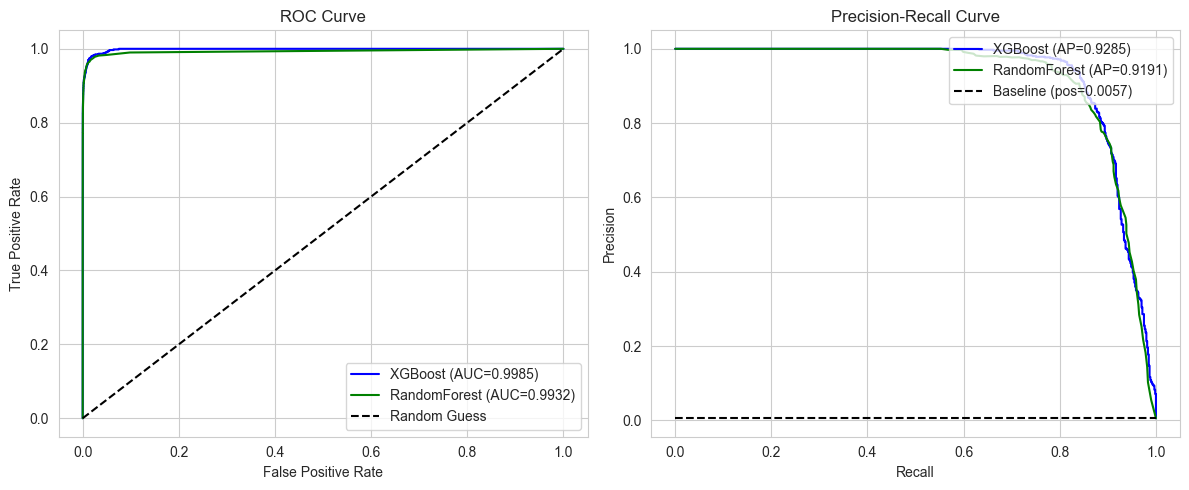

'\nInterpretation:\n - ROC AUC near 1.0 => excellent ability to discriminate between classes.\n - Precision-Recall Curve is key for imbalanced data. The area under it (AP)\n   measures how well the model identifies positives (fraud) among all predictions.\n\nIf you see high PR AUC (Average Precision), that suggests the model\ndoes quite well at catching the minority class with fewer false positives.\n\nYou can also experiment with threshold tuning by analyzing these curves \n(and picking a threshold that balances precision vs. recall as desired).\n'

In [17]:
###############################################################################
# CONTINUATION: PLOT ROC & PRECISION-RECALL CURVES (XGBoost & RandomForest)
###############################################################################
"""
Below code assumes you have already:
 - trained final_xgb and final_rf,
 - performed RFE transformations (X_test_sel_xgb, X_test_sel_rf),
 - have y_test as the true labels for the test set.

We'll plot:
   1) ROC Curve + AUC
   2) Precision-Recall Curve + Average Precision Score

Since this is a heavily imbalanced dataset, the PR curve can be more insightful.
"""

import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve, roc_auc_score, 
    precision_recall_curve, average_precision_score
)

# 1) GET PROBABILITY PREDICTIONS (for the positive class)
y_scores_xgb = final_xgb.predict_proba(X_test_sel_xgb)[:, 1]
y_scores_rf  = final_rf.predict_proba(X_test_sel_rf)[:, 1]

# 2) CALCULATE ROC CURVE & AUC
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_scores_xgb)
roc_auc_xgb         = roc_auc_score(y_test, y_scores_xgb)

fpr_rf, tpr_rf, _    = roc_curve(y_test, y_scores_rf)
roc_auc_rf           = roc_auc_score(y_test, y_scores_rf)

# 3) CALCULATE PRECISION-RECALL CURVE & AVERAGE PRECISION
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, y_scores_xgb)
avg_precision_xgb            = average_precision_score(y_test, y_scores_xgb)

precision_rf, recall_rf, _   = precision_recall_curve(y_test, y_scores_rf)
avg_precision_rf             = average_precision_score(y_test, y_scores_rf)

# 4) PLOT ROC & PR CURVES SIDE BY SIDE
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# --- ROC CURVE (LEFT) ---
axes[0].plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC={roc_auc_xgb:.4f})", color="blue")
axes[0].plot(fpr_rf, tpr_rf, label=f"RandomForest (AUC={roc_auc_rf:.4f})", color="green")
axes[0].plot([0,1], [0,1], 'k--', label="Random Guess")
axes[0].set_title("ROC Curve")
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].legend(loc="lower right")

# --- PRECISION-RECALL CURVE (RIGHT) ---
axes[1].plot(recall_xgb, precision_xgb, 
             label=f"XGBoost (AP={avg_precision_xgb:.4f})", color="blue")
axes[1].plot(recall_rf, precision_rf, 
             label=f"RandomForest (AP={avg_precision_rf:.4f})", color="green")

# Optional baseline: fraction of positives in y_test
pos_frac = (y_test == 1).mean()
axes[1].plot([0,1], [pos_frac, pos_frac], 'k--', label=f"Baseline (pos={pos_frac:.4f})")

axes[1].set_title("Precision-Recall Curve")
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")
axes[1].legend(loc="upper right")

plt.tight_layout()
plt.show()

"""
Interpretation:
 - ROC AUC near 1.0 => excellent ability to discriminate between classes.
 - Precision-Recall Curve is key for imbalanced data. The area under it (AP)
   measures how well the model identifies positives (fraud) among all predictions.

If you see high PR AUC (Average Precision), that suggests the model
does quite well at catching the minority class with fewer false positives.

You can also experiment with threshold tuning by analyzing these curves 
(and picking a threshold that balances precision vs. recall as desired).
"""


In [18]:
comp_df.to_csv("model_predictions.csv", index=False)


In [20]:
#predict the fpr -false positive rate - fewer false alarms - more accurate
# ppv precision - fewer false positives - more accurate
# fdr - false discovery rate - fewer false positives - more accurate
#specificity - fewer false negatives - more accurate (fewer false positives)
#research on thresholding 

=== XGBoost - Confusion Matrix ===
[[104154    103]
 [    74    527]]

=== XGBoost - Metrics ===
Accuracy: 0.9983
Precision (PPV): 0.8365
Recall (TPR): 0.8769
Specificity (TNR): 0.9990
FPR: 0.0010
FDR: 0.1635
NPV: 0.9993
FOR: 0.0007

=== RandomForest - Confusion Matrix ===
[[104205     52]
 [    96    505]]

=== RandomForest - Metrics ===
Accuracy: 0.9986
Precision (PPV): 0.9066
Recall (TPR): 0.8403
Specificity (TNR): 0.9995
FPR: 0.0005
FDR: 0.0934
NPV: 0.9991
FOR: 0.0009

=== Classification Reports (Sklearn) ===
[XGBoost]
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    104257
           1       0.84      0.88      0.86       601

    accuracy                           1.00    104858
   macro avg       0.92      0.94      0.93    104858
weighted avg       1.00      1.00      1.00    104858

[RandomForest]
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    104257
           1      

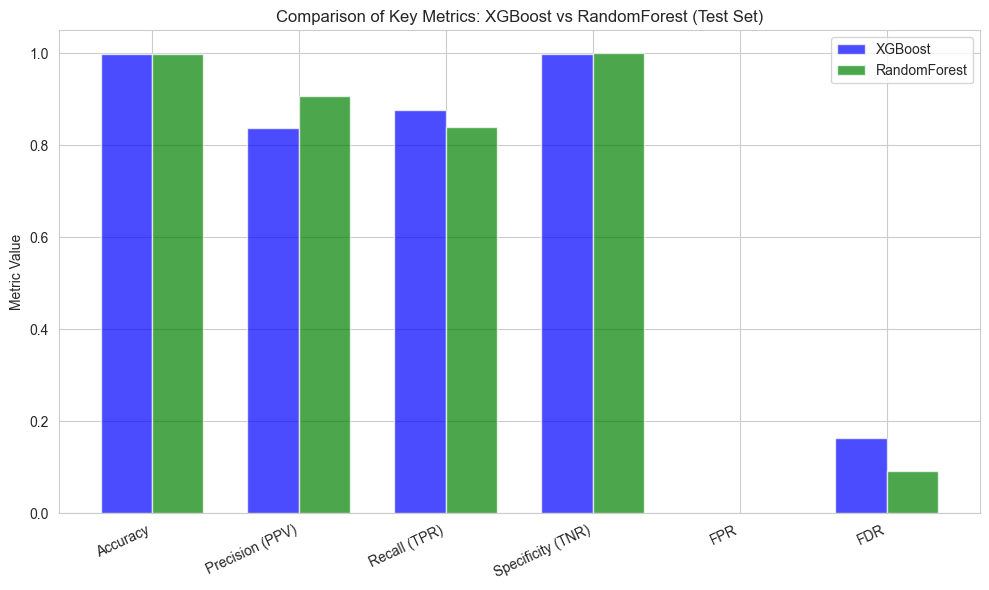

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# 1) Predict on TEST SET for both models
y_pred_xgb = final_xgb.predict(X_test_sel_xgb)
y_pred_rf  = final_rf.predict(X_test_sel_rf)

# 2) Get confusion matrices
cm_xgb = confusion_matrix(y_test, y_pred_xgb)  # [[TN, FP],[FN, TP]]
cm_rf  = confusion_matrix(y_test, y_pred_rf)

tn_xgb, fp_xgb, fn_xgb, tp_xgb = cm_xgb.ravel()
tn_rf,  fp_rf,  fn_rf,  tp_rf  = cm_rf.ravel()

# 3) Calculate metrics for XGBoost
acc_xgb = (tp_xgb + tn_xgb) / (tn_xgb + fp_xgb + fn_xgb + tp_xgb)
prec_xgb = tp_xgb / (tp_xgb + fp_xgb) if (tp_xgb + fp_xgb) else 0
rec_xgb = tp_xgb / (tp_xgb + fn_xgb)  if (tp_xgb + fn_xgb) else 0
spec_xgb = tn_xgb / (tn_xgb + fp_xgb) if (tn_xgb + fp_xgb) else 0
fpr_xgb = 1 - spec_xgb
fdr_xgb = 1 - prec_xgb

# Optionally: negative predictive value, etc.
npv_xgb = tn_xgb / (tn_xgb + fn_xgb) if (tn_xgb + fn_xgb) else 0
for_xgb = 1 - npv_xgb  # false omission rate

# 4) Calculate metrics for Random Forest
acc_rf = (tp_rf + tn_rf) / (tn_rf + fp_rf + fn_rf + tp_rf)
prec_rf = tp_rf / (tp_rf + fp_rf) if (tp_rf + fp_rf) else 0
rec_rf = tp_rf / (tp_rf + fn_rf)  if (tp_rf + fn_rf) else 0
spec_rf = tn_rf / (tn_rf + fp_rf) if (tn_rf + fp_rf) else 0
fpr_rf = 1 - spec_rf
fdr_rf = 1 - prec_rf

# Optional as well
npv_rf = tn_rf / (tn_rf + fn_rf) if (tn_rf + fn_rf) else 0
for_rf = 1 - npv_rf

# 5) Print or store metrics in a structured way
metrics_xgb = {
    "Accuracy": acc_xgb,
    "Precision (PPV)": prec_xgb,
    "Recall (TPR)": rec_xgb,
    "Specificity (TNR)": spec_xgb,
    "FPR": fpr_xgb,
    "FDR": fdr_xgb,
    "NPV": npv_xgb,
    "FOR": for_xgb
}

metrics_rf = {
    "Accuracy": acc_rf,
    "Precision (PPV)": prec_rf,
    "Recall (TPR)": rec_rf,
    "Specificity (TNR)": spec_rf,
    "FPR": fpr_rf,
    "FDR": fdr_rf,
    "NPV": npv_rf,
    "FOR": for_rf
}

print("=== XGBoost - Confusion Matrix ===")
print(cm_xgb)
print("\n=== XGBoost - Metrics ===")
for k, v in metrics_xgb.items():
    print(f"{k}: {v:.4f}")

print("\n=== RandomForest - Confusion Matrix ===")
print(cm_rf)
print("\n=== RandomForest - Metrics ===")
for k, v in metrics_rf.items():
    print(f"{k}: {v:.4f}")

print("\n=== Classification Reports (Sklearn) ===")
print("[XGBoost]\n", classification_report(y_test, y_pred_xgb))
print("[RandomForest]\n", classification_report(y_test, y_pred_rf))

# 6) OPTIONAL: Create a small dataframe to compare metrics side by side
comparison_df = pd.DataFrame({
    "XGBoost": metrics_xgb,
    "RandomForest": metrics_rf
}).T  # transpose so that each row is XGBoost vs. RandomForest
print("\n=== Side-by-Side Metric Comparison ===")
print(comparison_df)

# 7) OPTIONAL: Plot a grouped bar chart of these metrics
# Select whichever metrics you find most relevant for visualization
metrics_to_plot = ["Accuracy", "Precision (PPV)", "Recall (TPR)", "Specificity (TNR)", "FPR", "FDR"]

plt.figure(figsize=(10,6))
bar_width = 0.35
x = np.arange(len(metrics_to_plot))

xgboost_values = [metrics_xgb[m] for m in metrics_to_plot]
rf_values      = [metrics_rf[m] for m in metrics_to_plot]

plt.bar(x - bar_width/2, xgboost_values, width=bar_width, color='blue', alpha=0.7, label='XGBoost')
plt.bar(x + bar_width/2, rf_values, width=bar_width, color='green', alpha=0.7, label='RandomForest')

plt.xticks(ticks=x, labels=metrics_to_plot, rotation=25, ha='right')
plt.ylabel("Metric Value")
plt.title("Comparison of Key Metrics: XGBoost vs RandomForest (Test Set)")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
#grid search cv - hyperparameter tuning